# import

In [1]:
import numpy as np
import keras, os, cv2, glob, sys
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten

from keras.layers import Convolution2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
from keras.applications import InceptionV3, ResNet152V2, Xception, VGG16, VGG19, DenseNet121, MobileNet, DenseNet201, NASNetLarge, InceptionResNetV2
from keras import models, layers, Model
from keras.callbacks import EarlyStopping
from skimage.io import imread
from skimage.transform import resize
from tqdm import tqdm
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.applications.densenet import preprocess_input
import tracemalloc
import gc
import warnings
warnings.filterwarnings("ignore")

In [2]:
def get_process_memory():
    """Return total memory used by current PID, **including** memory in shared libraries
    """
    raw = os.popen(f"pmap {os.getpid()}").read()
    # The last line of pmap output gives the total memory like
    # " total            40140K"
    memory_mb = int(raw.split("\n")[-2].split()[-1].strip("K")) // 1024
    return memory_mb

In [3]:
def bytes_to_mb(size_in_bytes):
    size_in_mb = size_in_bytes / (1024.0 ** 2)
    return size_in_mb

## create dataSet

In [4]:
def create_dataSet(_path_data, _csv_data, CATEGORIES):

    data=pd.DataFrame(columns= ['file', 'labels'])

    c=0
    #cat_names = os.listdir(_path_data)
    for j in tqdm(CATEGORIES):
        pathfile = _path_data+'/'+j
        filenames = os.listdir(pathfile)
        for i in filenames:
          #print(_path_data+'/'+j+'/'+i)
          data.loc[c] = [str(_path_data+'/'+j+'/'+i), j]
          c=c+1
    #print(c)
    data.to_csv(_csv_data, index = False, header=True)
    data_csv = pd.read_csv(_csv_data)
    print(_csv_data)
    print(data_csv.groupby('labels').count())

    return data

## unlabelSet

In [5]:
def create_unlabelSet(_unlabels):
  unlabelsBD=pd.DataFrame(columns= ['file'])
  c=0
  filenames = os.listdir(_unlabels)
  for i in filenames:
    #print(_unlabels+'/'+i)
    unlabelsBD.loc[c] = [str(_unlabels+'/'+i)]
    c=c+1
  print(c)
  return unlabelsBD

## create folders

In [6]:
def create_folders(save_dir, flag=1):
  if os.path.isdir(save_dir):
    if flag:
      raise FileNotFoundError("folders test already exists: ", save_dir)
    else:
      print('folders test already exists: ', save_dir)
  else:
      os.mkdir(save_dir)
      print('create folders test: ', save_dir)

## create folder Tests

In [7]:
#Criar pasta dos testes
def criarTestes(_path, nmTeste):
  # nome do teste: modelo+size+aug
  _dir_test = _path+'/Train_'+nmTeste+'/'
  print('folders test: ',_dir_test)
  create_folders(_dir_test, flag=0)
  return _dir_test, nmTeste

## split data

In [8]:
def splitData(data_csv, _path, _base):
  prod_csv, test_csv = train_test_split(data_csv, test_size=0.2, shuffle=True)
  train_csv, val_csv = train_test_split(prod_csv, test_size=0.2, shuffle=True)
  #print('Train ',train_csv.shape)
  #print('Test ',test_csv.shape)

  #Salvar split data
  _csv_train=_path+'/'+_base+'_trainSet.csv'
  _csv_test=_path+'/'+_base+'_testSet.csv'
  _csv_val=_path+'/'+_base+'_valSet.csv'
  train_csv.to_csv(_csv_train, index = False, header=True)
  test_csv.to_csv(_csv_test, index = False, header=True)
  val_csv.to_csv(_csv_val, index = False, header=True)

  training_data = pd.read_csv(_csv_train)
  print('\n Train split')
  print(training_data.groupby('labels').count())
  test_data = pd.read_csv(_csv_test)
  print('\n Test split')
  print(test_data.groupby('labels').count())

  val_data = pd.read_csv(_csv_val)
  print('\n Val split')
  print(val_data.groupby('labels').count())

  return training_data,val_data,test_data

## Augmentation

In [9]:
def aug_param(_aug):
    #Augmentation
    print('\n ######## Data Generator ################')
    #https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

    if _aug=='sem':
        aug=dict(rescale=1./255)
    if _aug== 'aug0':
        aug=dict(rescale=1./255,
                 brightness_range=[0.2,0.8],
                 horizontal_flip = True)

    idg = ImageDataGenerator(**aug)
    return idg

## load_data

In [10]:
def load_data(training_data, val_data, _aug):
  idg = aug_param(_aug)

  train_data_generator = idg.flow_from_dataframe(training_data,
                                            x_col = "file",
                                            y_col = "labels",
                                            target_size=(224, 224),
                                            class_mode = "categorical",
                                            shuffle = True)
  valid_data_generator = idg.flow_from_dataframe(val_data,
                                                x_col = "file",
                                                y_col = "labels",
                                                target_size=(224, 224),
                                                class_mode = "categorical",
                                                shuffle = True)
  return train_data_generator, valid_data_generator

# Select models

## DenseNet201

In [11]:
def tl_DenseNet201(input_shape):
    conv_base = DenseNet201(weights='imagenet',
                          include_top=False,
                          input_shape=input_shape)

    for layer in conv_base.layers:
      layer.trainable = False

    return conv_base

In [12]:
def new_DenseNet201(conv_base, CATEGORIES):
  model = models.Sequential()
  model.add(conv_base)

  model.add(layers.GlobalAveragePooling2D())
  model.add(layers.BatchNormalization())
  model.add(layers.Flatten())

  model.add(layers.Dense(2048, activation='relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.BatchNormalization())

  model.add(layers.Dense(len(CATEGORIES), activation='softmax'))  #5
  model.compile(loss='categorical_crossentropy',
                  optimizer='Adam',
                  metrics=['accuracy'])
  return model

## Mobilenet

In [13]:
def tl_Mobilenet(input_shape):
    conv_base = MobileNet(weights='imagenet',
                          include_top=False,
                          input_shape=input_shape)

    for layer in conv_base.layers:
      layer.trainable = False

    return conv_base

In [14]:
def new_Mobilenet(conv_base, CATEGORIES):
  model = models.Sequential()
  model.add(conv_base)
  model.add(layers.GlobalAveragePooling2D())
  model.add(layers.BatchNormalization())
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dropout(0.6))
  model.add(layers.Dense(len(CATEGORIES), activation='softmax'))
  model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
  return model

## InceptionV3

In [15]:
def tl_InceptionV3(input_shape):
    conv_base = InceptionV3(weights='imagenet',
                          include_top=False,
                          input_shape=input_shape)

    for layer in conv_base.layers:
      layer.trainable = False

    return conv_base



In [16]:
def new_InceptionV3(conv_base, CATEGORIES):
  model = models.Sequential()
  model.add(conv_base)

  model.add(layers.Flatten())
  model.add(layers.Dense(1024, activation='relu'))
  model.add(layers.Dropout(0.2))

  model.add(layers.Dense(len(CATEGORIES), activation='softmax'))

  model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
  return model

## InceptionResNetV2

In [17]:
def tl_InceptionResNetV2(input_shape):
    conv_base = InceptionResNetV2(weights='imagenet',
                          include_top=False,
                          input_shape=input_shape)

    for layer in conv_base.layers:
      layer.trainable = False

    return conv_base



In [18]:
def new_InceptionResNetV2(conv_base, CATEGORIES):
  model = models.Sequential()
  model.add(conv_base)

  model.add(layers.Flatten())
  model.add(layers.Dense(1024, activation='relu'))
  model.add(layers.Dropout(0.2))

  model.add(layers.Dense(len(CATEGORIES), activation='softmax'))

  model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
  return model

## ResNet152V2

In [19]:
def tl_ResNet152V2(input_shape):
    conv_base = ResNet152V2(weights='imagenet',
                            include_top=False,
                            input_shape=input_shape)

    for layer in conv_base.layers:
      layer.trainable = False

    return conv_base

In [20]:
def new_ResNet152V2(conv_base, CATEGORIES):
  model = models.Sequential()
  model.add(conv_base)
  model.add(layers.GlobalAveragePooling2D())
  model.add(layers.BatchNormalization())
  model.add(layers.Flatten())

  model.add(layers.Dense(2048, activation='relu'))
  model.add(layers.Dropout(0.8))
  model.add(layers.BatchNormalization())


  model.add(layers.Dense(len(CATEGORIES), activation='softmax'))  #5
  model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  #optimizer=optimizers.RMSprop(learning_rate=2e-5),
                  metrics=['accuracy'])
  return model

## Xception

In [21]:
def tl_Xception(input_shape):
    conv_base = Xception(weights='imagenet',
                            include_top=False,
                            input_shape=input_shape)

    for layer in conv_base.layers:
      layer.trainable = False

    return conv_base

In [22]:
def new_Xception(conv_base, CATEGORIES):
  model = models.Sequential()
  model.add(conv_base)

  model.add(layers.GlobalAveragePooling2D())

  model.add(layers.Dense(len(CATEGORIES), activation='softmax'))  #5
  model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  #optimizer=optimizers.RMSprop(learning_rate=2e-5),
                  metrics=['accuracy'])
  return model

## VGG16

In [23]:
def tl_VGG16(input_shape):
    conv_base = VGG16(weights='imagenet',
                            include_top=False,
                            input_shape=input_shape)

    for layer in conv_base.layers:
      layer.trainable = False

    return conv_base

In [24]:
def new_VGG16(conv_base, CATEGORIES):
  model = models.Sequential()
  model.add(conv_base)

  model.add(layers.Flatten())
  model.add(layers.Dense(2048, activation='relu'))
  model.add(layers.Dropout(0.4))
  model.add(layers.Dense(1024, activation='relu'))
  model.add(layers.Dropout(0.4))

  model.add(layers.Dense(len(CATEGORIES), activation='softmax'))  #5
  model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  #optimizer=optimizers.RMSprop(learning_rate=2e-5),
                  metrics=['accuracy'])
  return model

## VGG19

In [25]:
def tl_VGG19(input_shape):
    conv_base = VGG16(weights='imagenet',
                            include_top=False,
                            input_shape=input_shape)

    for layer in conv_base.layers:
      layer.trainable = False

    return conv_base

In [26]:
def new_VGG19(conv_base, CATEGORIES):
  model = models.Sequential()
  model.add(conv_base)

  model.add(layers.Flatten())
  model.add(layers.Dense(2048, activation='relu'))
  model.add(layers.Dropout(0.4))
  model.add(layers.Dense(1024, activation='relu'))
  model.add(layers.Dropout(0.4))

  model.add(layers.Dense(len(CATEGORIES), activation='softmax'))  #5
  model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  #optimizer=optimizers.RMSprop(learning_rate=2e-5),
                  metrics=['accuracy'])
  return model

In [27]:
def sel_cnn(_model, input_shape, CATEGORIES):
  if _model == 'InceptionResNetV2':
    conv_base=tl_InceptionResNetV2(input_shape)
    model = new_InceptionResNetV2(conv_base, CATEGORIES)

  if _model == 'DenseNet201':
    conv_base=tl_DenseNet201(input_shape)
    model = new_DenseNet201(conv_base, CATEGORIES)

  if _model == 'Mobilenet':
    conv_base=tl_Mobilenet(input_shape)
    model = new_Mobilenet(conv_base, CATEGORIES)

  if _model == 'InceptionV3':
    conv_base=tl_InceptionV3(input_shape)
    model = new_InceptionV3(conv_base, CATEGORIES)

  if _model == 'ResNet152V2':
    conv_base=tl_ResNet152V2(input_shape)
    model = new_ResNet152V2(conv_base, CATEGORIES)
  if _model == 'Xception':
      conv_base=tl_Xception(input_shape)
      model = new_Xception(conv_base, CATEGORIES)
  if _model == 'VGG16':
      conv_base=tl_VGG16(input_shape)
      model = new_VGG16(conv_base, CATEGORIES)
  if _model == 'VGG19':
      conv_base=tl_VGG19(input_shape)
      model = new_VGG19(conv_base, CATEGORIES)
  model.summary()
  return model

# 03 - fit

In [28]:
def fitModels(_tempo, save_dir, model_inst, train_data_generator, valid_data_generator,
              epochs, alpha, CATEGORIES, input_shape, verbose=2):
  print(save_dir+'bestLoss_'+str(_tempo)+'.h5')
  if verbose==2:
    cp_loss = ModelCheckpoint(save_dir+'bestLoss_'+str(_tempo)+'.h5',
                                  monitor='val_loss', verbose=1,
                                  save_weights_only=True, mode='min')
    es = EarlyStopping(monitor='val_loss', mode='min',  patience = 5, verbose=1)
    lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, min_delta=alpha, patience=5, verbose=1)
    nm_log=save_dir+'_log.csv'
    csv_log = CSVLogger(nm_log)
    callbacks_list = [cp_loss, es, lr]
  else:
    callbacks_list=[]
  history = model_inst.fit(train_data_generator,
              epochs=epochs,
              callbacks=callbacks_list,
              validation_data=valid_data_generator)
  #4-plot Accuracy
  pd_history = pd.DataFrame(history.history)
  pd_history.plot()
  plt.grid(True)
  if verbose==2:
    plt.savefig(save_dir+str(_tempo)+'_acc_loss.jpg')
  plt.show()

  return model_inst


In [29]:
_ID_DATA = 'v2'
_DESC_DATA='Modo 2-Dados carregados via ImageDatagen '

def load_img(data, input_shape):
  x=[]
  fnames,labels = data['file'],data['labels']
  for f in tqdm(fnames):
        img=imread(f)
        x.append(resize(img,output_shape=input_shape))
  return np.array(x),labels.values

# 04 - Relatório

## plot matrix confusion

In [30]:
def plot_mat_confux(y_test, y_pred, CATEGORIES, save_dir, _tempo):
  fig_size=(8,8)
  mat =confusion_matrix(y_test, y_pred, normalize='pred')
  plt.figure(figsize = fig_size)
  ax= plt.subplot()
  sns.heatmap(mat, cmap="Blues",annot=True); #annot=True to annotate cells

  ax.set_xticklabels(ax.get_xticklabels(),
                     rotation=45, horizontalalignment='right')
  ax.set_yticklabels(ax.get_yticklabels(),
                     rotation=45, horizontalalignment='right')

  # labels, title and ticks
  ax.set_xlabel('Rótulos previstos');
  ax.set_ylabel('Rótulos verdadeiros');
  ax.set_title('Matriz de confusão');
  ax.xaxis.set_ticklabels(CATEGORIES);
  ax.yaxis.set_ticklabels(CATEGORIES);
  plt.savefig(save_dir+str(_tempo)+'_mat_conf.jpg')
  plt.show()

  return mat

In [31]:
def metricas(y_true, y_pred, Eval_valid):
  acc= metrics.accuracy_score(y_true, y_pred)
  precision, recall, fscore, support = metrics.precision_recall_fscore_support(y_true, y_pred)
  kappa = metrics.cohen_kappa_score(y_true, y_pred)
  me = round(Eval_valid[0], 2), round(Eval_valid[1], 2), round(acc, 2), round(np.mean(precision, axis=0), 2), round(np.mean(recall, axis=0), 2), round(np.mean(fscore, axis=0),2), round(kappa, 2)
  print(me)
  return me

In [32]:
def evalution(_tempo,save_dir, test, input_shape, CATEGORIES, val, model_inst):
  model_inst.load_weights(save_dir+'bestLoss_'+str(_tempo)+'.h5')
  X_test,y_test=load_img(test, input_shape)
  pred=np.argmax(model_inst.predict(X_test), axis=-1)

  y_pred = [CATEGORIES[y] for y in pred] # convert

  df=pd.DataFrame(columns= ['k','fnames', 'labels', 'predic'])

  print('\n------------filtro de classificação errada---------------')
  print('k - fnames - labes - predic')
  for i in range(len(y_pred)):
    a=test.iloc[i][0]
    b=y_test[i]
    c=y_pred[i]
    if b!=c:
      print(i,'-',a,'-',b,'-', c)
      df.loc[i] = [_tempo,a,b,c]
  print(len(df))
  df.to_csv(save_dir+'filterWong'+str(_tempo)+'.csv', index= True)

  #plot mat
  mc=plot_mat_confux(y_test, y_pred, CATEGORIES, save_dir, _tempo)
  print('Classification Report')
  print(classification_report(y_test, y_pred))

  #metricas
  Eval_valid = model_inst.evaluate(val)
  me=metricas(y_test, y_pred, Eval_valid)
  return me

In [33]:
def load_img_un(data, input_shape):
  x=[]
  for f in tqdm(data['file']):
        img=imread(f)
        img = preprocess_input(img)
        x.append(resize(img,output_shape=input_shape))

  return np.array(x)

# classifica

In [34]:
def classificaImgs(_path_model, _tempo, _model, data_total, _pseudo_csv, CATEGORIES,
                   input_shape, tipo='png', resize_shape=(224,224), verbose=1):
  print('\nClass-instanciando o modelo')
  model_inst = None
  model_inst=sel_cnn(_model, input_shape, CATEGORIES)

  print('\nClass-carregando os pesos do modelo')
  path=_path_model+'/bestLoss_'+str(_tempo)+'.h5'
  print(path)
  model_inst.load_weights(path)

  print('\nClass-carregando as imagens da classe---> unlabel ')
  total=len(data_total)
  ini=0
  bat=3
  passo=total//bat
  fim=passo

  #criar um data frame com X, Y
  dataF=pd.DataFrame(columns= ['file', 'labels', 'conf'])

  for i in range(bat):
    print('ini ', ini, ' fim ', fim)
    data=data_total[ini:fim]
    data=pd.DataFrame(data, columns= ['file'])
    X=load_img_un(data, resize_shape)
    print('\nClass-classificando as imagens : ',X.shape)
    if len(X)<1:
      break

    preds=model_inst.predict(X)
    confia=100*np.max(preds)

    pred=np.argmax(preds, axis=-1)
    y_pred = [CATEGORIES[y] for y in pred] # convert

    col='labels'
    data.insert(data.shape[1], column=col, value=y_pred)
    col='conf'
    data.insert(data.shape[1], column=col, value=confia)
    #dataF.append(data, ignore_index = True)
    dataF = pd.concat([dataF, data], ignore_index=True, sort=False)
    ini=fim
    fim=fim+fim
    if fim>total:
      fim=total

  print('build')
  _csv_unlabels_t= _pseudo_csv+'/unlabelSet_t'+str(_tempo)+'.csv'
  print(f"\nClass-salvando unlabels tempo {_tempo}, {_csv_unlabels_t}")
  dataF.to_csv(_csv_unlabels_t, index = False, header=True)
  print(dataF.groupby('labels').count())
  print('Total de dados classificados ',len(dataF))
  n = gc.collect()
  print("Número de objetos coletados pela função GC:", n)
  print("Objetos restantes:", gc.garbage)

# Seleção

In [35]:
def selec(_csv_unlabels_t, flag, unlabels_csv, _pseudo_csv, CATEGORIES, _tempo, train_data_csv):
  data_uns=pd.read_csv(_csv_unlabels_t)
  if len(data_uns)==0:
    flag=False
  else:
    print('\nSelect- Filtrar por confiança')
    new_data_uns=data_uns.loc[data_uns['conf']>95]
    new_data_uns.drop('conf', axis=1, inplace=True)

    print('Select- Tamanho data_uns', len(new_data_uns))
    if len(new_data_uns)==0:
      print('new_data_uns, não passou pelo filtro de 95%')
      flag=False
    lista=[]
    for cat in CATEGORIES:
        df = new_data_uns[new_data_uns['labels'] == cat]
        size=len(df)
        print(cat, size)
        lista.append(size)
    menor=min(lista)
    if menor<100:
      menor=100
    elif menor==0:
      menor =100
    print('Select- menor', menor)
    print('\nSelect- seleção de novos pseudos')
    df_sel=pd.DataFrame(columns= ['file','labels'])
    
    print('\n--------------build-----------------')
    for cat in CATEGORIES:
        print('\ncategoria ',cat, 'quantidade ',len(df))
        df = new_data_uns[new_data_uns['labels'] == cat]
        df_sel=pd.concat([df_sel, df[:menor]], ignore_index = True)

    print('Select- Total de dados selecioandos ', len(df_sel))
    if len(df_sel)>0:
      for i in df_sel['file']:
        unlabels_csv.drop(unlabels_csv[unlabels_csv['file'] == i].index, inplace = True)
    else:
      flag=False
    print('Select- Total de excluídos       ', len(df_sel))
    print('Select- Total depois da Exclusão ', len(unlabels_csv))

    _csv_unlabels_t= _pseudo_csv+'/unlabelSet_t'+str(_tempo+1)+'.csv'
    print('Select- Select- salvando unlabels depois da Exclusão ',_csv_unlabels_t)
    unlabels_csv.to_csv(_csv_unlabels_t, index = False, header=True)

    print('\nSelect- Tamanho do train anterior', len(train_data_csv))
    New_train_data = pd.concat([train_data_csv, df_sel], ignore_index=True, sort=False)
    print('Select- Tamanho do novo train      ', len(New_train_data))

    #salva o novo TrainSet
    _csv_New_data = _pseudo_csv+'/trainSet_T'+str(_tempo+1)+'.csv'
    New_train_data.to_csv(_csv_New_data, index = False, header=True)

    if len(unlabels_csv)==0:
      flag=False

  return New_train_data, flag, len(df_sel)

## step_1

In [36]:
def step_1(nm, _model, _aug, _base, _labels):
  print('\nrun.1-criar a pasta raiz')
  """
  cria pasta raiz dos lotes de testes, exemplo
  '/content/drive/MyDrive/CPD1/CLASS_PSEUDO_build'
  """
  create_folders(_path, flag=0)

  print('\nrun.2-criar a pasta teste')
  """
  cria pasta raiz do modelo, exemplo
  .../0_MobileNet_sem_BI_5
  """
  nmTeste=str(nm)+'_'+_model+'_'+_aug+'_'+_base
  Teste=_path+'/'+nmTeste
  create_folders(Teste, flag=0)

  print('\nrun.3-criar o Train')
  """
  cria pasta raiz do modelo, exemplo
  .../0_MobileNet_sem_BI_5/Train_0_Mobilenet_sem_BI_5
  """
  save_dir_train, id=criarTestes(Teste, nmTeste)

  print('\nrun.4-Criar a pasta pseudo_csv')
  _pseudo_csv=save_dir_train+'pseudo_csv'
  create_folders(_pseudo_csv, flag=0)

  print('\nrun.5-criar o csv')
  _csv_data= _path+'/'+_base+'.csv' # pastas
  CATEGORIES = sorted(os.listdir(_labels))
  data_csv=create_dataSet(_labels, _csv_data, CATEGORIES)
  print('Total de dados rotulados ', len(data_csv))

  print('\nrun.6-split data')
  training_data, val_data, test=splitData(data_csv, _path, _base)

  return training_data, val_data, test, CATEGORIES, save_dir_train, _pseudo_csv, len(data_csv)

## step 2

In [37]:
def step_2(_model, _base, _aug, input_shape, CATEGORIES, save_dir_test,
           training_data, val_data, test, _tempo, epochs, alpha):
  print('step 2')

  print('\nstep 2.1-load data train')
  train, val=load_data(training_data, val_data, _aug)

  print('\nstep 2.2-instanciando o modelo')
  model_inst = None
  model_inst=sel_cnn(_model, input_shape, CATEGORIES)
  print('\nstep 2.3-train')
  model_inst=fitModels(_tempo, save_dir_test, model_inst, train, val,
              epochs, alpha, CATEGORIES, input_shape, verbose=2)
  print('\nstep 2.4-Evalution')
  print(f"########################### fim tempo {_tempo} #############")
  me=evalution(_tempo,save_dir_test, test, input_shape, CATEGORIES, val, model_inst)
  n = gc.collect()
  print("Número de objetos coletados pela função GC:", n)
  print("Objetos restantes:", gc.garbage)

  return me

## step 3

In [38]:
def step_3(_tempo, _pseudo_csv, _unlabels, _path_train, _path_model, _model, CATEGORIES, input_shape):
  """
  1-ler a base unlabels
  2-classificar os dados unlabels
  3-filtrar por confiança
  4-seleção de novos pseudos
  5-regras de parada
  """
  print('step 3')
  print(f"step3 -tempo {_tempo}")
  print('_pseudo_csv', _pseudo_csv)
  #criar newBD
  flag=True

  if _tempo==0:
    print('\nstep 3.2- create_unlabelSet')
    """
    tempo=0, unlabelSet é o da base:
    '/content/drive/MyDrive/CPD1/BD_BI/BI_5/unlabels'
    """
    unlabels_csv=create_unlabelSet(_unlabels)
    train_data_csv = pd.read_csv(_path_train)
  else:
    print('\nstep 3.3- create_new_unlabelSet')
    """
    tempo=1 ou +, new_unlabelSet é criado o caminho para a pasta pseudo_csv:
    '.../pseudo_csv/unlabelSet_t1'
    """
    _csv_new_unlabels= _pseudo_csv+'/unlabelSet_t'+str(_tempo)+'.csv'
    unlabels_csv=pd.read_csv(_csv_new_unlabels)

    _path_new_train=_pseudo_csv+'/trainSet_T'+str(_tempo)+'.csv'
    train_data_csv = pd.read_csv(_path_new_train)

  sizeOfunlabels=len(unlabels_csv)
  if sizeOfunlabels<10:
    flag=False
  else:
    print('Total de dados não rotulados ', sizeOfunlabels)
    print('\nStep 3.4- Classificação')
    classificaImgs(_path_model, _tempo, _model, unlabels_csv, _pseudo_csv,
                  CATEGORIES, input_shape, tipo='png', resize_shape=(224,224), verbose=1)

    print('\nStep 3.5- Seleção')
    _csv_unlabels_t= _pseudo_csv+'/unlabelSet_t'+str(_tempo)+'.csv'

    New_train_data, flag, sizeOfselect=selec(_csv_unlabels_t, flag, unlabels_csv,
                                            _pseudo_csv, CATEGORIES, _tempo, train_data_csv)
  return New_train_data, flag, sizeOfunlabels, sizeOfselect

## step 4

In [39]:
def step_4(input_shape, CATEGORIES, save_dir_test, train, val, test, _tempo, _model, epochs, alpha):
  print('step 4')
  loss_anterior=_tempo-1
  print('\n 4-recarregando o modelo', 'bestLoss_'+str(loss_anterior))

  print('\nstep 2.2-instanciando o modelo')
  model_inst = None
  model_inst=sel_cnn(_model, input_shape, CATEGORIES)

  _load_weights=save_dir_test+'/bestLoss_'+str(loss_anterior)+'.h5'
  model_inst.load_weights(_load_weights)

  print('\n 5-train')
  model_inst=fitModels(_tempo, save_dir_test, model_inst, train, val,
              epochs, alpha, CATEGORIES, input_shape, verbose=2)
  print('\n 6-Evalution')
  me=evalution(_tempo,save_dir_test, test, input_shape, CATEGORIES, val, model_inst)
  return model_inst, me


# run

In [40]:
def run(nm, _path,_model,  _aug, _base, _path_BD):

  _tempo=0
  _labels =_path_BD+'/labels'
  _unlabels=_path_BD+'/unlabels'
  _path_train=_path+'/'+_base+'_trainSet.csv'


  # Constantes
  epochs = 500
  alpha    = 1e-5
  img_size=224
  input_shape  = (img_size, img_size, 3)
  ME=[]
  TABLE=[]

  #tempo =0
  """
  Tempo=0:
  1-criar a pasta raiz
  2-criar a pasta teste
  3-criar o Train
  4-criar a pasta pseudo_csv
  5-criar o csv
  6-split data
  ---- step 2
  7-load data train
  8-Treinar o modelo
  9-Evalution
  ---- step 3
  10 - classificar
  11 - selecionar
  """

  print('\nrun.step_0')
  training_data, val_data, test, CATEGORIES, save_dir_train, _pseudo_csv, sizeOflabels=step_1(nm, _model, _aug, _base, _labels)



  print('\nrun.step_2')
  me=step_2(_model, _base, _aug, input_shape, CATEGORIES,
                        save_dir_train, training_data, val_data, test, _tempo, epochs, alpha)
  ME.append(me)


  while True:
    print('\nrun.step_3')
    New_train_data, flag, sizeOfunLabels, sizeOfselect=step_3(_tempo,_pseudo_csv,
                                                              _unlabels, _path_train, save_dir_train, _model, CATEGORIES, input_shape)
    if _tempo==0:
      TABLE.append([_tempo, sizeOflabels, sizeOfunLabels, me[0], me[1], sizeOfselect])
    print(flag)
    if flag==False:
      print('Terminando por falta de dados.... ')
      break
    _tempo=_tempo+1
    print('################### Tempo #################### ')
    print(_tempo)
    train, val=load_data(New_train_data, val_data, _aug)
    model_inst, me=step_4(input_shape, CATEGORIES, save_dir_train, train, val, test, _tempo, _model, epochs, alpha)
    ME.append(me)

    #Tempo, rotulados, não rotulados, val_loss, val_acc, acc, seleção
    sizeOflabels=sizeOflabels+sizeOflabels
    TABLE.append([_tempo, sizeOflabels, sizeOfunLabels, me[0], me[1], sizeOfselect])

    print('tempo, rotulados, não rotulados, val_loss, val_acc, acc, seleção')
    print(TABLE)


  ### save metricas
  _csv_me_test= save_dir_train+'metrics_test.csv'
  metrics_test=pd.DataFrame(columns= ['tempo', 'val_loss','val_acc','accuracy','precision', 'recall', 'fscore', 'kappa' ])
  #print('accuracy','precision', 'recall', 'fscore', 'kappa')
  Eval_valid = model_inst.evaluate(val)

  for i in range(int(_tempo)):
      metrics_test.loc[i]=i, ME[i][0], ME[i][1], ME[i][2], ME[i][3], ME[i][4], ME[i][5], ME[i][6]
  metrics_test.loc['Mean']=round(metrics_test.mean(),4)
  metrics_test.loc['Std']=round(metrics_test.std(),4)

  metrics_test.to_csv(_csv_me_test, index = False, header=True)
  print(metrics_test)

  ## save Table
  _csv_table=save_dir_train+'table_test.csv'
  table_test=pd.DataFrame(columns= ['tempo', 'rotulados', 'não rotulados', 'val_loss', 'val_acc', 'acc', 'seleção'])


  for i in range(int(_tempo)):
    table_test.loc[i]=i, TABLE[i][0], TABLE[i][1], TABLE[i][2], TABLE[i][3], TABLE[i][4], TABLE[i][5], TABLE[i][6]

  table_test.to_csv(_csv_table, index = False, header=True)
  print(table_test)

# Main

0 Mobilenet sem

run.step_0

run.1-criar a pasta raiz
folders test already exists:  C:\Users\jczarsGamer\anaconda3\PSEUDO_LABELLING\CLASS_PSEUDO

run.2-criar a pasta teste
folders test already exists:  C:\Users\jczarsGamer\anaconda3\PSEUDO_LABELLING\CLASS_PSEUDO/0_Mobilenet_sem_BI_5

run.3-criar o Train
folders test:  C:\Users\jczarsGamer\anaconda3\PSEUDO_LABELLING\CLASS_PSEUDO/0_Mobilenet_sem_BI_5/Train_0_Mobilenet_sem_BI_5/
folders test already exists:  C:\Users\jczarsGamer\anaconda3\PSEUDO_LABELLING\CLASS_PSEUDO/0_Mobilenet_sem_BI_5/Train_0_Mobilenet_sem_BI_5/

run.4-Criar a pasta pseudo_csv
folders test already exists:  C:\Users\jczarsGamer\anaconda3\PSEUDO_LABELLING\CLASS_PSEUDO/0_Mobilenet_sem_BI_5/Train_0_Mobilenet_sem_BI_5/pseudo_csv

run.5-criar o csv


100%|██████████| 6/6 [00:00<00:00, 17.92it/s]


C:\Users\jczarsGamer\anaconda3\PSEUDO_LABELLING\CLASS_PSEUDO/BI_5.csv
                     file
labels                   
equatorial_alongada    70
equatorial_circular   231
equatorial_eliptica    44
polar_circular        150
polar_triangular      105
polar_tricircular      35
Total de dados rotulados  635

run.6-split data

 Train split
                     file
labels                   
equatorial_alongada    42
equatorial_circular   155
equatorial_eliptica    28
polar_circular         87
polar_triangular       69
polar_tricircular      25

 Test split
                     file
labels                   
equatorial_alongada    16
equatorial_circular    40
equatorial_eliptica     8
polar_circular         38
polar_triangular       16
polar_tricircular       9

 Val split
                     file
labels                   
equatorial_alongada    12
equatorial_circular    36
equatorial_eliptica     8
polar_circular         25
polar_triangular       20
polar_tricircular       1

run.step_2

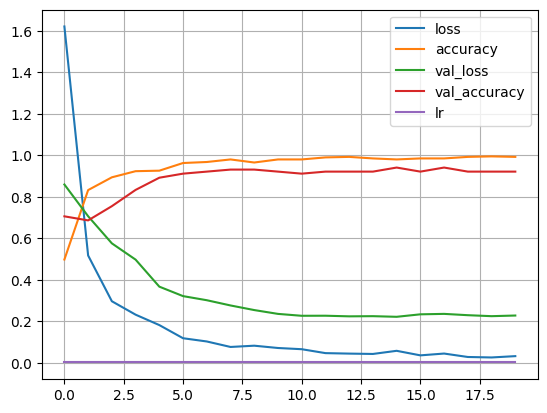


step 2.4-Evalution
########################### fim tempo 0 #############


100%|██████████| 127/127 [00:01<00:00, 108.88it/s]


4/4 [==============================] - 1s 49ms/step

------------filtro de classificação errada---------------
k - fnames - labes - predic
16 - C:\Users\jczarsGamer\anaconda3\PSEUDO_LABELLING\BI_5/labels/equatorial_eliptica/14.Sinapis (44).png - equatorial_eliptica - equatorial_circular
29 - C:\Users\jczarsGamer\anaconda3\PSEUDO_LABELLING\BI_5/labels/polar_circular/10.Satureja (37).png - polar_circular - equatorial_circular
40 - C:\Users\jczarsGamer\anaconda3\PSEUDO_LABELLING\BI_5/labels/polar_circular/9.Origanum (133).png - polar_circular - equatorial_eliptica
58 - C:\Users\jczarsGamer\anaconda3\PSEUDO_LABELLING\BI_5/labels/polar_circular/10.Satureja (27).png - polar_circular - equatorial_circular
63 - C:\Users\jczarsGamer\anaconda3\PSEUDO_LABELLING\BI_5/labels/polar_circular/9.Origanum (39).png - polar_circular - equatorial_circular
65 - C:\Users\jczarsGamer\anaconda3\PSEUDO_LABELLING\BI_5/labels/equatorial_circular/20.Olea (10).png - equatorial_circular - equatorial_eliptica
86 - C:

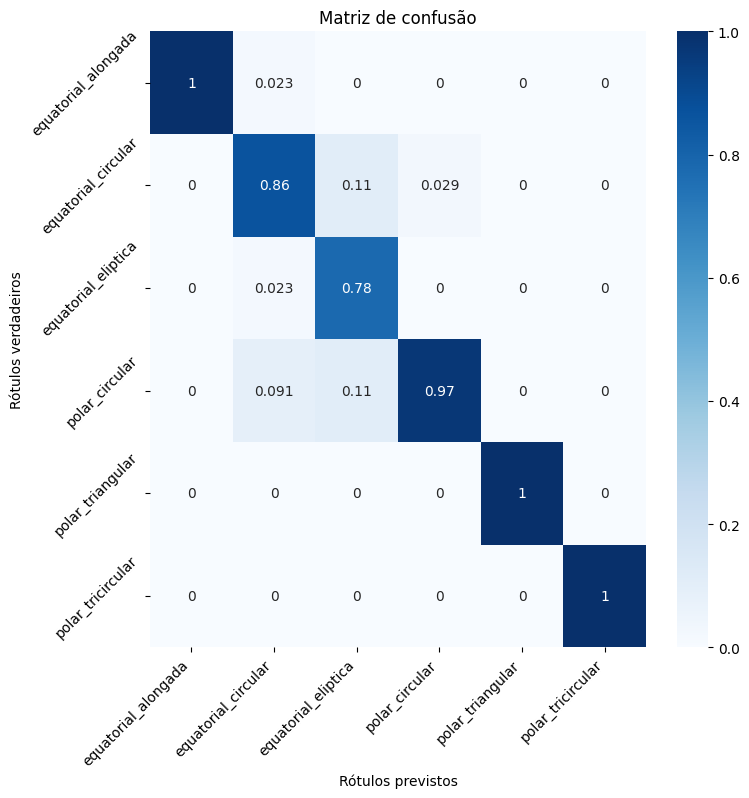

Classification Report
                     precision    recall  f1-score   support

equatorial_alongada       1.00      0.94      0.97        16
equatorial_circular       0.86      0.95      0.90        40
equatorial_eliptica       0.78      0.88      0.82         8
     polar_circular       0.97      0.87      0.92        38
   polar_triangular       1.00      1.00      1.00        16
  polar_tricircular       1.00      1.00      1.00         9

           accuracy                           0.93       127
          macro avg       0.94      0.94      0.94       127
       weighted avg       0.93      0.93      0.93       127

4/4 [==============================] - 0s 40ms/step - loss: 0.2275 - accuracy: 0.9216
(0.23, 0.92, 0.93, 0.94, 0.94, 0.94, 0.91)
Número de objetos coletados pela função GC: 13244
Objetos restantes: []

run.step_3
step 3
step3 -tempo 0
_pseudo_csv C:\Users\jczarsGamer\anaconda3\PSEUDO_LABELLING\CLASS_PSEUDO/0_Mobilenet_sem_BI_5/Train_0_Mobilenet_sem_BI_5/pseudo_cs

100%|██████████| 1091/1091 [00:09<00:00, 110.59it/s]



Class-classificando as imagens :  (1091, 224, 224, 3)
35/35 [==============================] - 1s 26ms/step
ini  1091  fim  2182


100%|██████████| 1091/1091 [00:09<00:00, 110.59it/s]



Class-classificando as imagens :  (1091, 224, 224, 3)
35/35 [==============================] - 1s 26ms/step
ini  2182  fim  3273


100%|██████████| 1091/1091 [00:09<00:00, 110.74it/s]



Class-classificando as imagens :  (1091, 224, 224, 3)
35/35 [==============================] - 1s 27ms/step
build

Class-salvando unlabels tempo 0, C:\Users\jczarsGamer\anaconda3\PSEUDO_LABELLING\CLASS_PSEUDO/0_Mobilenet_sem_BI_5/Train_0_Mobilenet_sem_BI_5/pseudo_csv/unlabelSet_t0.csv
                     file  conf
labels                         
equatorial_alongada   251   251
equatorial_circular  1232  1232
equatorial_eliptica    68    68
polar_circular        198   198
polar_triangular     1366  1366
polar_tricircular     158   158
Total de dados classificados  3273
Número de objetos coletados pela função GC: 11359
Objetos restantes: []

Step 3.5- Seleção

Select- Filtrar por confiança
Select- Tamanho data_uns 3273
equatorial_alongada 251
equatorial_circular 1232
equatorial_eliptica 68
polar_circular 198
polar_triangular 1366
polar_tricircular 158
Select- menor 100

Select- seleção de novos pseudos

--------------build-----------------
\categoria     equatorial_alongada
tamanho do

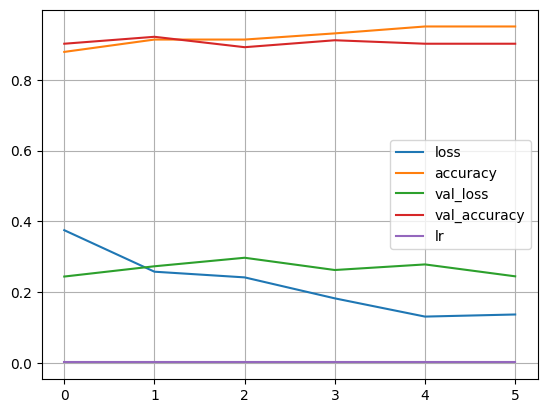


 6-Evalution


100%|██████████| 127/127 [00:01<00:00, 107.47it/s]


4/4 [==============================] - 0s 45ms/step

------------filtro de classificação errada---------------
k - fnames - labes - predic
29 - C:\Users\jczarsGamer\anaconda3\PSEUDO_LABELLING\BI_5/labels/polar_circular/10.Satureja (37).png - polar_circular - equatorial_circular
37 - C:\Users\jczarsGamer\anaconda3\PSEUDO_LABELLING\BI_5/labels/equatorial_circular/8.Vitis (11).png - equatorial_circular - equatorial_alongada
40 - C:\Users\jczarsGamer\anaconda3\PSEUDO_LABELLING\BI_5/labels/polar_circular/9.Origanum (133).png - polar_circular - equatorial_eliptica
58 - C:\Users\jczarsGamer\anaconda3\PSEUDO_LABELLING\BI_5/labels/polar_circular/10.Satureja (27).png - polar_circular - equatorial_circular
63 - C:\Users\jczarsGamer\anaconda3\PSEUDO_LABELLING\BI_5/labels/polar_circular/9.Origanum (39).png - polar_circular - equatorial_circular
65 - C:\Users\jczarsGamer\anaconda3\PSEUDO_LABELLING\BI_5/labels/equatorial_circular/20.Olea (10).png - equatorial_circular - equatorial_eliptica
86 - C:\Us

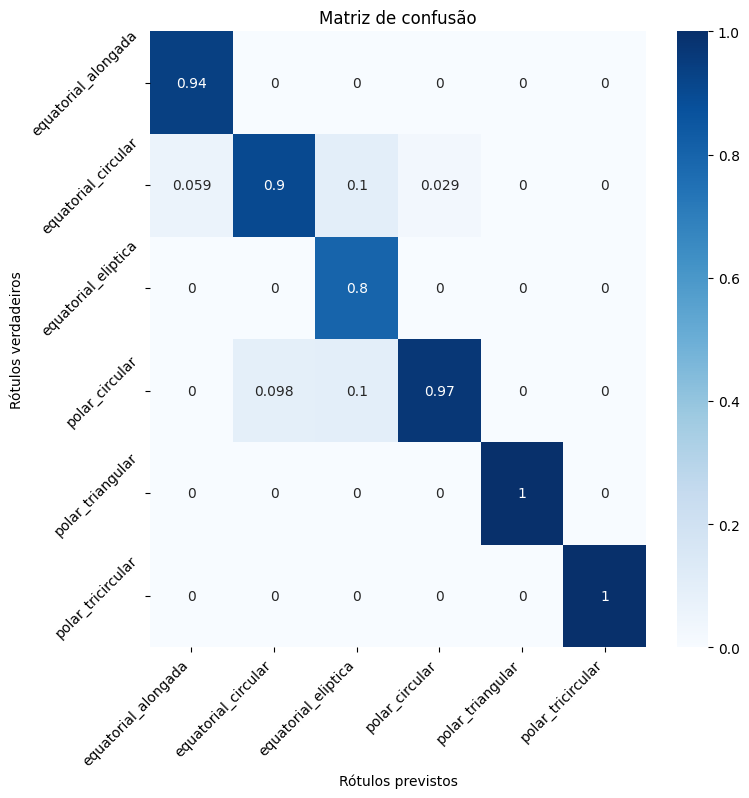

Classification Report
                     precision    recall  f1-score   support

equatorial_alongada       0.94      1.00      0.97        16
equatorial_circular       0.90      0.93      0.91        40
equatorial_eliptica       0.80      1.00      0.89         8
     polar_circular       0.97      0.87      0.92        38
   polar_triangular       1.00      1.00      1.00        16
  polar_tricircular       1.00      1.00      1.00         9

           accuracy                           0.94       127
          macro avg       0.94      0.97      0.95       127
       weighted avg       0.94      0.94      0.94       127

4/4 [==============================] - 0s 41ms/step - loss: 0.2445 - accuracy: 0.9020
(0.24, 0.9, 0.94, 0.94, 0.97, 0.95, 0.92)
tempo, rotulados, não rotulados, val_loss, val_acc, acc, seleção
[[0, 635, 3273, 0.23, 0.92, 568], [1, 1270, 3273, 0.24, 0.9, 568]]

run.step_3
step 3
step3 -tempo 1
_pseudo_csv C:\Users\jczarsGamer\anaconda3\PSEUDO_LABELLING\CLASS_PSEUD

100%|██████████| 901/901 [00:08<00:00, 112.49it/s]



Class-classificando as imagens :  (901, 224, 224, 3)
29/29 [==============================] - 1s 27ms/step
ini  901  fim  1802


100%|██████████| 901/901 [00:08<00:00, 111.29it/s]



Class-classificando as imagens :  (901, 224, 224, 3)
29/29 [==============================] - 1s 33ms/step
ini  1802  fim  2705


100%|██████████| 903/903 [00:08<00:00, 112.76it/s]



Class-classificando as imagens :  (903, 224, 224, 3)
29/29 [==============================] - 1s 34ms/step
build

Class-salvando unlabels tempo 1, C:\Users\jczarsGamer\anaconda3\PSEUDO_LABELLING\CLASS_PSEUDO/0_Mobilenet_sem_BI_5/Train_0_Mobilenet_sem_BI_5/pseudo_csv/unlabelSet_t1.csv
                     file  conf
labels                         
equatorial_alongada   171   171
equatorial_circular  1092  1092
equatorial_eliptica    16    16
polar_circular         76    76
polar_triangular     1238  1238
polar_tricircular     112   112
Total de dados classificados  2705
Número de objetos coletados pela função GC: 31009
Objetos restantes: []

Step 3.5- Seleção

Select- Filtrar por confiança
Select- Tamanho data_uns 2705
equatorial_alongada 171
equatorial_circular 1092
equatorial_eliptica 16
polar_circular 76
polar_triangular 1238
polar_tricircular 112
Select- menor 100

Select- seleção de novos pseudos

--------------build-----------------
\categoria     equatorial_alongada
tamanho do d

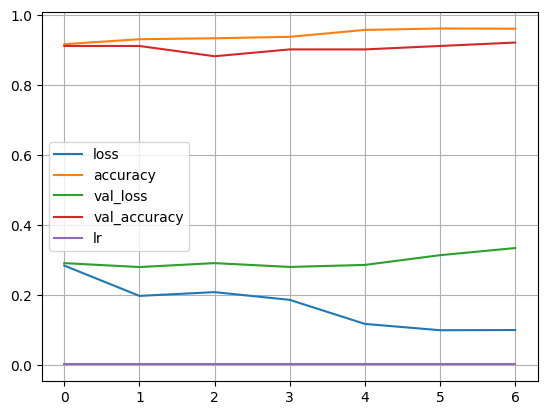


 6-Evalution


100%|██████████| 127/127 [00:01<00:00, 103.93it/s]


4/4 [==============================] - 0s 51ms/step

------------filtro de classificação errada---------------
k - fnames - labes - predic
6 - C:\Users\jczarsGamer\anaconda3\PSEUDO_LABELLING\BI_5/labels/equatorial_circular/20.Olea (43).png - equatorial_circular - polar_tricircular
29 - C:\Users\jczarsGamer\anaconda3\PSEUDO_LABELLING\BI_5/labels/polar_circular/10.Satureja (37).png - polar_circular - equatorial_circular
37 - C:\Users\jczarsGamer\anaconda3\PSEUDO_LABELLING\BI_5/labels/equatorial_circular/8.Vitis (11).png - equatorial_circular - equatorial_alongada
40 - C:\Users\jczarsGamer\anaconda3\PSEUDO_LABELLING\BI_5/labels/polar_circular/9.Origanum (133).png - polar_circular - equatorial_circular
63 - C:\Users\jczarsGamer\anaconda3\PSEUDO_LABELLING\BI_5/labels/polar_circular/9.Origanum (39).png - polar_circular - equatorial_circular
65 - C:\Users\jczarsGamer\anaconda3\PSEUDO_LABELLING\BI_5/labels/equatorial_circular/20.Olea (10).png - equatorial_circular - equatorial_eliptica
86 - C:

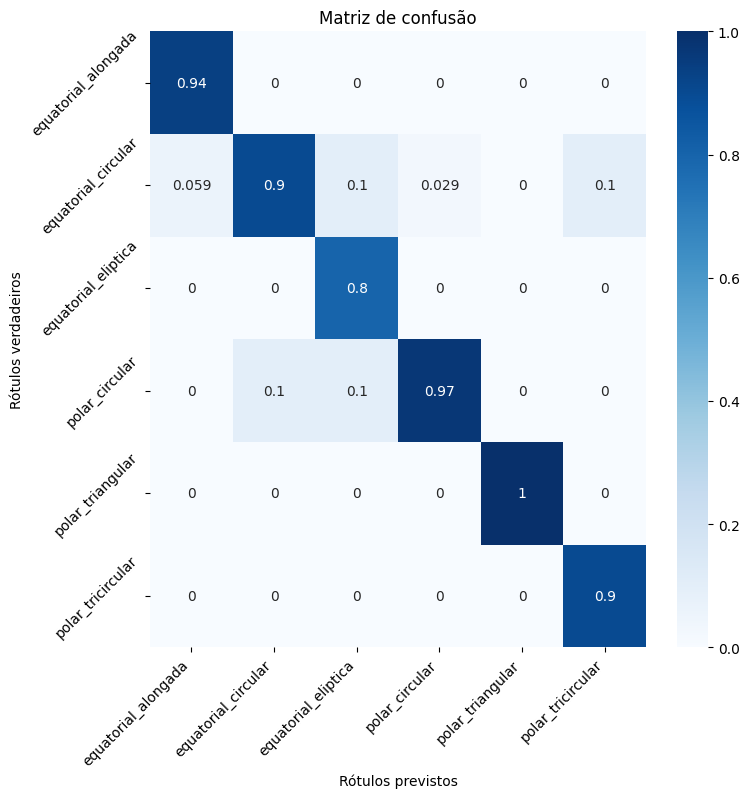

Classification Report
                     precision    recall  f1-score   support

equatorial_alongada       0.94      1.00      0.97        16
equatorial_circular       0.90      0.90      0.90        40
equatorial_eliptica       0.80      1.00      0.89         8
     polar_circular       0.97      0.87      0.92        38
   polar_triangular       1.00      1.00      1.00        16
  polar_tricircular       0.90      1.00      0.95         9

           accuracy                           0.93       127
          macro avg       0.92      0.96      0.94       127
       weighted avg       0.93      0.93      0.93       127

4/4 [==============================] - 0s 43ms/step - loss: 0.3341 - accuracy: 0.9216
(0.33, 0.92, 0.93, 0.92, 0.96, 0.94, 0.91)
tempo, rotulados, não rotulados, val_loss, val_acc, acc, seleção
[[0, 635, 3273, 0.23, 0.92, 568], [1, 1270, 3273, 0.24, 0.9, 568], [2, 2540, 2705, 0.33, 0.92, 492]]

run.step_3
step 3
step3 -tempo 2
_pseudo_csv C:\Users\jczarsGamer\ana

100%|██████████| 737/737 [00:06<00:00, 106.02it/s]



Class-classificando as imagens :  (737, 224, 224, 3)
24/24 [==============================] - 1s 29ms/step
ini  737  fim  1474


100%|██████████| 737/737 [00:06<00:00, 108.79it/s]



Class-classificando as imagens :  (737, 224, 224, 3)
24/24 [==============================] - 1s 36ms/step
ini  1474  fim  2213


100%|██████████| 739/739 [00:06<00:00, 108.13it/s]



Class-classificando as imagens :  (739, 224, 224, 3)
24/24 [==============================] - 1s 33ms/step
build

Class-salvando unlabels tempo 2, C:\Users\jczarsGamer\anaconda3\PSEUDO_LABELLING\CLASS_PSEUDO/0_Mobilenet_sem_BI_5/Train_0_Mobilenet_sem_BI_5/pseudo_csv/unlabelSet_t2.csv
                     file  conf
labels                         
equatorial_alongada    77    77
equatorial_circular   746   746
equatorial_eliptica    13    13
polar_circular         16    16
polar_triangular      968   968
polar_tricircular     393   393
Total de dados classificados  2213
Número de objetos coletados pela função GC: 40468
Objetos restantes: []

Step 3.5- Seleção

Select- Filtrar por confiança
Select- Tamanho data_uns 2213
equatorial_alongada 77
equatorial_circular 746
equatorial_eliptica 13
polar_circular 16
polar_triangular 968
polar_tricircular 393
Select- menor 100

Select- seleção de novos pseudos

--------------build-----------------
\categoria     equatorial_alongada
tamanho do df 3

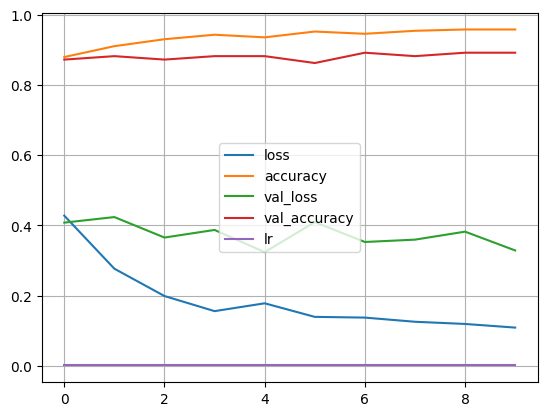


 6-Evalution


100%|██████████| 127/127 [00:01<00:00, 108.71it/s]


4/4 [==============================] - 0s 40ms/step

------------filtro de classificação errada---------------
k - fnames - labes - predic
29 - C:\Users\jczarsGamer\anaconda3\PSEUDO_LABELLING\BI_5/labels/polar_circular/10.Satureja (37).png - polar_circular - equatorial_circular
37 - C:\Users\jczarsGamer\anaconda3\PSEUDO_LABELLING\BI_5/labels/equatorial_circular/8.Vitis (11).png - equatorial_circular - equatorial_alongada
40 - C:\Users\jczarsGamer\anaconda3\PSEUDO_LABELLING\BI_5/labels/polar_circular/9.Origanum (133).png - polar_circular - equatorial_eliptica
58 - C:\Users\jczarsGamer\anaconda3\PSEUDO_LABELLING\BI_5/labels/polar_circular/10.Satureja (27).png - polar_circular - equatorial_circular
63 - C:\Users\jczarsGamer\anaconda3\PSEUDO_LABELLING\BI_5/labels/polar_circular/9.Origanum (39).png - polar_circular - equatorial_circular
65 - C:\Users\jczarsGamer\anaconda3\PSEUDO_LABELLING\BI_5/labels/equatorial_circular/20.Olea (10).png - equatorial_circular - equatorial_eliptica
86 - C:\Us

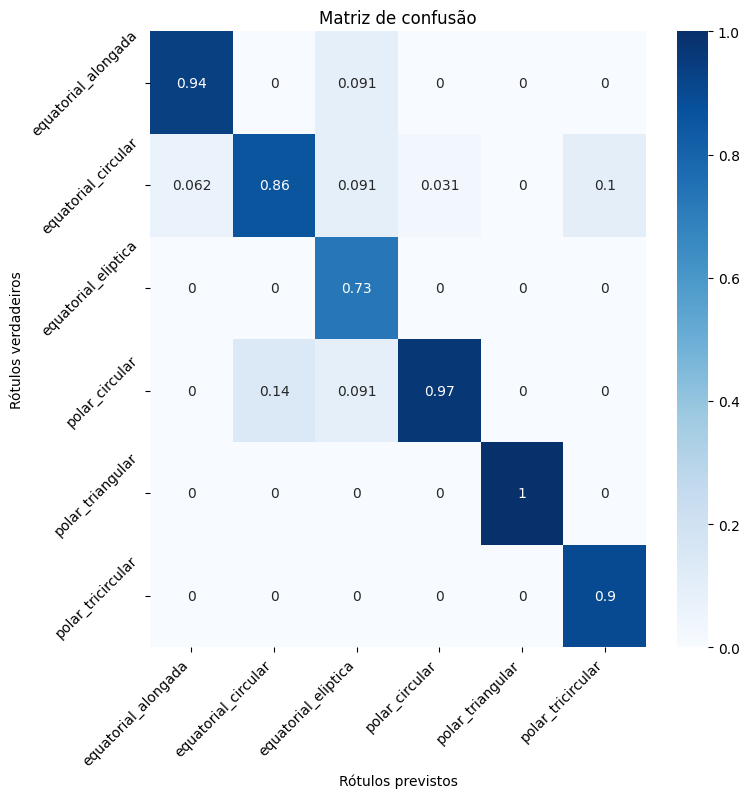

Classification Report
                     precision    recall  f1-score   support

equatorial_alongada       0.94      0.94      0.94        16
equatorial_circular       0.86      0.90      0.88        40
equatorial_eliptica       0.73      1.00      0.84         8
     polar_circular       0.97      0.82      0.89        38
   polar_triangular       1.00      1.00      1.00        16
  polar_tricircular       0.90      1.00      0.95         9

           accuracy                           0.91       127
          macro avg       0.90      0.94      0.92       127
       weighted avg       0.91      0.91      0.91       127

4/4 [==============================] - 0s 42ms/step - loss: 0.3286 - accuracy: 0.8922
(0.33, 0.89, 0.91, 0.9, 0.94, 0.92, 0.88)
tempo, rotulados, não rotulados, val_loss, val_acc, acc, seleção
[[0, 635, 3273, 0.23, 0.92, 568], [1, 1270, 3273, 0.24, 0.9, 568], [2, 2540, 2705, 0.33, 0.92, 492], [3, 5080, 2213, 0.33, 0.89, 406]]

run.step_3
step 3
step3 -tempo 3
_ps

100%|██████████| 602/602 [00:05<00:00, 109.08it/s]



Class-classificando as imagens :  (602, 224, 224, 3)
19/19 [==============================] - 1s 39ms/step
ini  602  fim  1204


100%|██████████| 602/602 [00:05<00:00, 111.31it/s]



Class-classificando as imagens :  (602, 224, 224, 3)
19/19 [==============================] - 1s 45ms/step
ini  1204  fim  1807


100%|██████████| 603/603 [00:05<00:00, 110.09it/s]



Class-classificando as imagens :  (603, 224, 224, 3)
19/19 [==============================] - 1s 36ms/step
build

Class-salvando unlabels tempo 3, C:\Users\jczarsGamer\anaconda3\PSEUDO_LABELLING\CLASS_PSEUDO/0_Mobilenet_sem_BI_5/Train_0_Mobilenet_sem_BI_5/pseudo_csv/unlabelSet_t3.csv
                     file  conf
labels                         
equatorial_alongada     6     6
equatorial_circular   336   336
equatorial_eliptica     3     3
polar_circular          7     7
polar_triangular      837   837
polar_tricircular     618   618
Total de dados classificados  1807
Número de objetos coletados pela função GC: 36140
Objetos restantes: []

Step 3.5- Seleção

Select- Filtrar por confiança
Select- Tamanho data_uns 1807
equatorial_alongada 6
equatorial_circular 336
equatorial_eliptica 3
polar_circular 7
polar_triangular 837
polar_tricircular 618
Select- menor 100

Select- seleção de novos pseudos

--------------build-----------------
\categoria     equatorial_alongada
tamanho do df 618


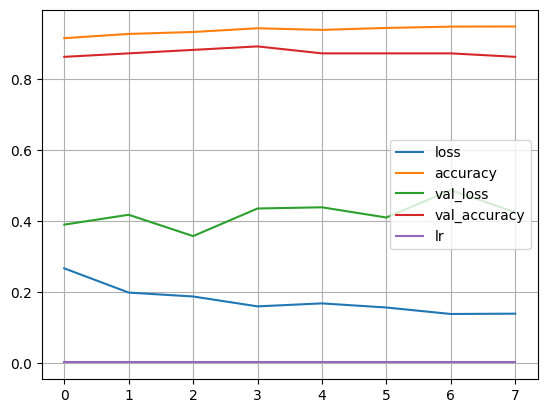


 6-Evalution


100%|██████████| 127/127 [00:01<00:00, 111.60it/s]


4/4 [==============================] - 0s 42ms/step

------------filtro de classificação errada---------------
k - fnames - labes - predic
29 - C:\Users\jczarsGamer\anaconda3\PSEUDO_LABELLING\BI_5/labels/polar_circular/10.Satureja (37).png - polar_circular - equatorial_circular
37 - C:\Users\jczarsGamer\anaconda3\PSEUDO_LABELLING\BI_5/labels/equatorial_circular/8.Vitis (11).png - equatorial_circular - equatorial_alongada
40 - C:\Users\jczarsGamer\anaconda3\PSEUDO_LABELLING\BI_5/labels/polar_circular/9.Origanum (133).png - polar_circular - equatorial_eliptica
58 - C:\Users\jczarsGamer\anaconda3\PSEUDO_LABELLING\BI_5/labels/polar_circular/10.Satureja (27).png - polar_circular - equatorial_circular
59 - C:\Users\jczarsGamer\anaconda3\PSEUDO_LABELLING\BI_5/labels/equatorial_circular/20.Olea (76).png - equatorial_circular - polar_tricircular
63 - C:\Users\jczarsGamer\anaconda3\PSEUDO_LABELLING\BI_5/labels/polar_circular/9.Origanum (39).png - polar_circular - equatorial_circular
65 - C:\User

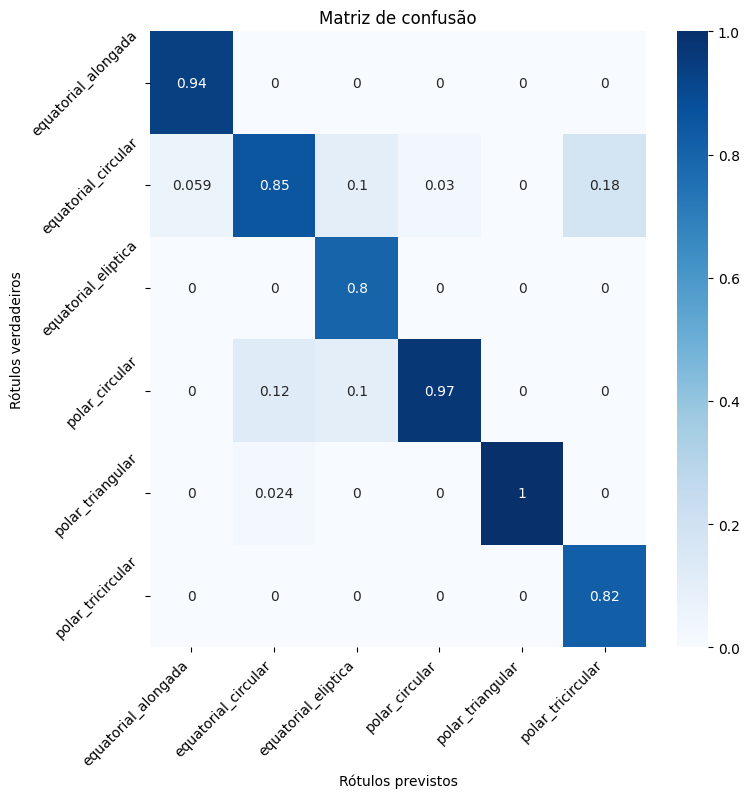

Classification Report
                     precision    recall  f1-score   support

equatorial_alongada       0.94      1.00      0.97        16
equatorial_circular       0.85      0.88      0.86        40
equatorial_eliptica       0.80      1.00      0.89         8
     polar_circular       0.97      0.84      0.90        38
   polar_triangular       1.00      0.94      0.97        16
  polar_tricircular       0.82      1.00      0.90         9

           accuracy                           0.91       127
          macro avg       0.90      0.94      0.92       127
       weighted avg       0.91      0.91      0.91       127

4/4 [==============================] - 0s 41ms/step - loss: 0.4246 - accuracy: 0.8627
(0.42, 0.86, 0.91, 0.9, 0.94, 0.92, 0.88)
tempo, rotulados, não rotulados, val_loss, val_acc, acc, seleção
[[0, 635, 3273, 0.23, 0.92, 568], [1, 1270, 3273, 0.24, 0.9, 568], [2, 2540, 2705, 0.33, 0.92, 492], [3, 5080, 2213, 0.33, 0.89, 406], [4, 10160, 1807, 0.42, 0.86, 316]]

r

100%|██████████| 497/497 [00:04<00:00, 109.75it/s]



Class-classificando as imagens :  (497, 224, 224, 3)
16/16 [==============================] - 1s 35ms/step
ini  497  fim  994


100%|██████████| 497/497 [00:04<00:00, 110.35it/s]



Class-classificando as imagens :  (497, 224, 224, 3)
16/16 [==============================] - 1s 43ms/step
ini  994  fim  1491


100%|██████████| 497/497 [00:04<00:00, 112.19it/s]



Class-classificando as imagens :  (497, 224, 224, 3)
16/16 [==============================] - 1s 37ms/step
build

Class-salvando unlabels tempo 4, C:\Users\jczarsGamer\anaconda3\PSEUDO_LABELLING\CLASS_PSEUDO/0_Mobilenet_sem_BI_5/Train_0_Mobilenet_sem_BI_5/pseudo_csv/unlabelSet_t4.csv
                     file  conf
labels                         
equatorial_circular   219   219
equatorial_eliptica     3     3
polar_circular         10    10
polar_triangular      772   772
polar_tricircular     487   487
Total de dados classificados  1491
Número de objetos coletados pela função GC: 38853
Objetos restantes: []

Step 3.5- Seleção

Select- Filtrar por confiança
Select- Tamanho data_uns 1491
equatorial_alongada 0
equatorial_circular 219
equatorial_eliptica 3
polar_circular 10
polar_triangular 772
polar_tricircular 487
Select- menor 100

Select- seleção de novos pseudos

--------------build-----------------
\categoria     equatorial_alongada
tamanho do df 487
new_data_uns  1491
\categoria  

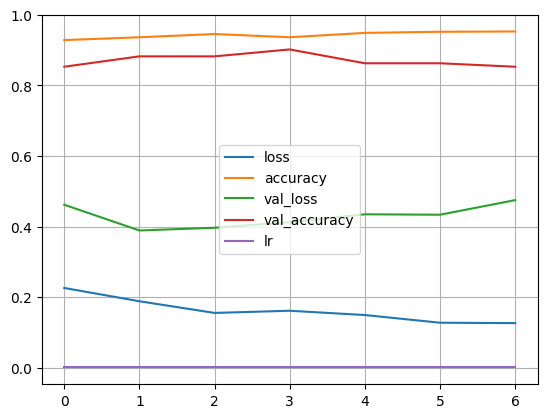


 6-Evalution


100%|██████████| 127/127 [00:01<00:00, 111.39it/s]


4/4 [==============================] - 0s 41ms/step

------------filtro de classificação errada---------------
k - fnames - labes - predic
6 - C:\Users\jczarsGamer\anaconda3\PSEUDO_LABELLING\BI_5/labels/equatorial_circular/20.Olea (43).png - equatorial_circular - polar_tricircular
29 - C:\Users\jczarsGamer\anaconda3\PSEUDO_LABELLING\BI_5/labels/polar_circular/10.Satureja (37).png - polar_circular - equatorial_circular
37 - C:\Users\jczarsGamer\anaconda3\PSEUDO_LABELLING\BI_5/labels/equatorial_circular/8.Vitis (11).png - equatorial_circular - equatorial_alongada
40 - C:\Users\jczarsGamer\anaconda3\PSEUDO_LABELLING\BI_5/labels/polar_circular/9.Origanum (133).png - polar_circular - equatorial_eliptica
57 - C:\Users\jczarsGamer\anaconda3\PSEUDO_LABELLING\BI_5/labels/equatorial_circular/20.Olea (44).png - equatorial_circular - polar_tricircular
59 - C:\Users\jczarsGamer\anaconda3\PSEUDO_LABELLING\BI_5/labels/equatorial_circular/20.Olea (76).png - equatorial_circular - polar_tricircular
63 -

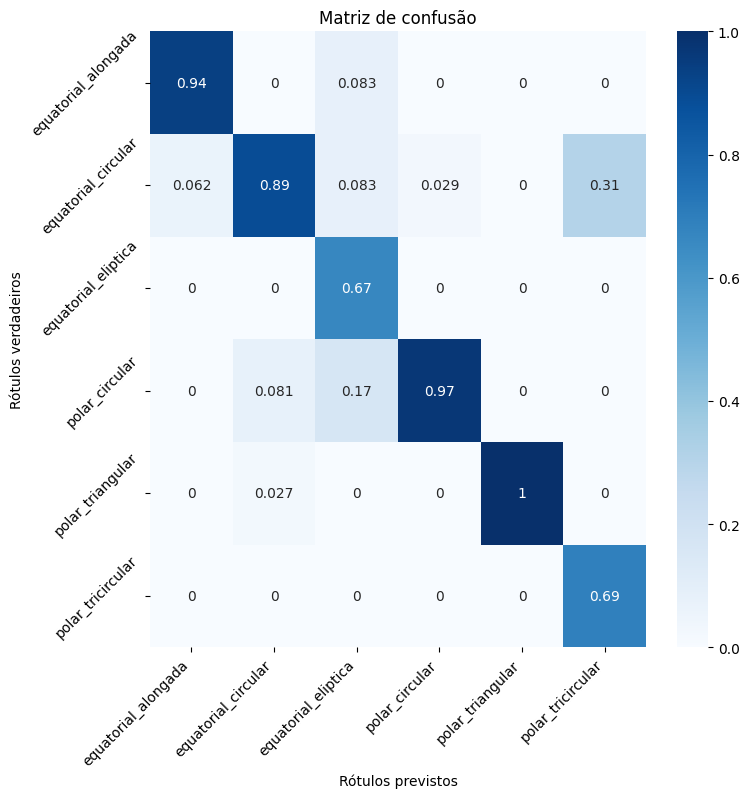

Classification Report
                     precision    recall  f1-score   support

equatorial_alongada       0.94      0.94      0.94        16
equatorial_circular       0.89      0.82      0.86        40
equatorial_eliptica       0.67      1.00      0.80         8
     polar_circular       0.97      0.87      0.92        38
   polar_triangular       1.00      0.94      0.97        16
  polar_tricircular       0.69      1.00      0.82         9

           accuracy                           0.89       127
          macro avg       0.86      0.93      0.88       127
       weighted avg       0.91      0.89      0.89       127

4/4 [==============================] - 0s 40ms/step - loss: 0.4753 - accuracy: 0.8529
(0.48, 0.85, 0.89, 0.86, 0.93, 0.88, 0.86)
tempo, rotulados, não rotulados, val_loss, val_acc, acc, seleção
[[0, 635, 3273, 0.23, 0.92, 568], [1, 1270, 3273, 0.24, 0.9, 568], [2, 2540, 2705, 0.33, 0.92, 492], [3, 5080, 2213, 0.33, 0.89, 406], [4, 10160, 1807, 0.42, 0.86, 316], [

100%|██████████| 392/392 [00:03<00:00, 110.58it/s]



Class-classificando as imagens :  (392, 224, 224, 3)
13/13 [==============================] - 1s 44ms/step
ini  392  fim  784


100%|██████████| 392/392 [00:03<00:00, 112.13it/s]



Class-classificando as imagens :  (392, 224, 224, 3)
13/13 [==============================] - 1s 40ms/step
ini  784  fim  1178


100%|██████████| 394/394 [00:03<00:00, 111.64it/s]



Class-classificando as imagens :  (394, 224, 224, 3)
13/13 [==============================] - 1s 39ms/step
build

Class-salvando unlabels tempo 5, C:\Users\jczarsGamer\anaconda3\PSEUDO_LABELLING\CLASS_PSEUDO/0_Mobilenet_sem_BI_5/Train_0_Mobilenet_sem_BI_5/pseudo_csv/unlabelSet_t5.csv
                     file  conf
labels                         
equatorial_alongada     7     7
equatorial_circular   106   106
equatorial_eliptica     5     5
polar_circular         13    13
polar_triangular      655   655
polar_tricircular     392   392
Total de dados classificados  1178
Número de objetos coletados pela função GC: 35428
Objetos restantes: []

Step 3.5- Seleção

Select- Filtrar por confiança
Select- Tamanho data_uns 1178
equatorial_alongada 7
equatorial_circular 106
equatorial_eliptica 5
polar_circular 13
polar_triangular 655
polar_tricircular 392
Select- menor 100

Select- seleção de novos pseudos

--------------build-----------------
\categoria     equatorial_alongada
tamanho do df 392

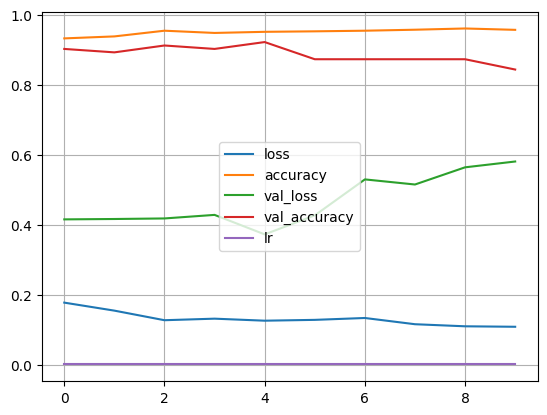


 6-Evalution


100%|██████████| 127/127 [00:01<00:00, 111.41it/s]


4/4 [==============================] - 0s 45ms/step

------------filtro de classificação errada---------------
k - fnames - labes - predic
6 - C:\Users\jczarsGamer\anaconda3\PSEUDO_LABELLING\BI_5/labels/equatorial_circular/20.Olea (43).png - equatorial_circular - polar_tricircular
29 - C:\Users\jczarsGamer\anaconda3\PSEUDO_LABELLING\BI_5/labels/polar_circular/10.Satureja (37).png - polar_circular - equatorial_circular
37 - C:\Users\jczarsGamer\anaconda3\PSEUDO_LABELLING\BI_5/labels/equatorial_circular/8.Vitis (11).png - equatorial_circular - equatorial_alongada
40 - C:\Users\jczarsGamer\anaconda3\PSEUDO_LABELLING\BI_5/labels/polar_circular/9.Origanum (133).png - polar_circular - equatorial_eliptica
57 - C:\Users\jczarsGamer\anaconda3\PSEUDO_LABELLING\BI_5/labels/equatorial_circular/20.Olea (44).png - equatorial_circular - polar_tricircular
59 - C:\Users\jczarsGamer\anaconda3\PSEUDO_LABELLING\BI_5/labels/equatorial_circular/20.Olea (76).png - equatorial_circular - polar_tricircular
63 -

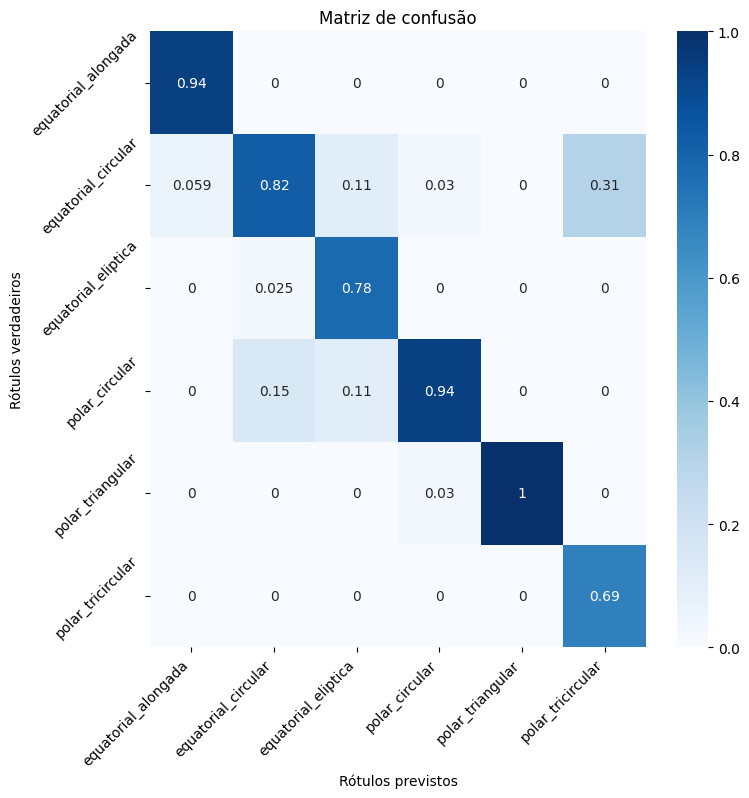

Classification Report
                     precision    recall  f1-score   support

equatorial_alongada       0.94      1.00      0.97        16
equatorial_circular       0.82      0.82      0.82        40
equatorial_eliptica       0.78      0.88      0.82         8
     polar_circular       0.94      0.82      0.87        38
   polar_triangular       1.00      0.94      0.97        16
  polar_tricircular       0.69      1.00      0.82         9

           accuracy                           0.87       127
          macro avg       0.86      0.91      0.88       127
       weighted avg       0.88      0.87      0.88       127

4/4 [==============================] - 0s 42ms/step - loss: 0.5805 - accuracy: 0.8431
(0.58, 0.84, 0.87, 0.86, 0.91, 0.88, 0.84)
tempo, rotulados, não rotulados, val_loss, val_acc, acc, seleção
[[0, 635, 3273, 0.23, 0.92, 568], [1, 1270, 3273, 0.24, 0.9, 568], [2, 2540, 2705, 0.33, 0.92, 492], [3, 5080, 2213, 0.33, 0.89, 406], [4, 10160, 1807, 0.42, 0.86, 316], [

100%|██████████| 284/284 [00:02<00:00, 111.52it/s]



Class-classificando as imagens :  (284, 224, 224, 3)
9/9 [==============================] - 1s 58ms/step
ini  284  fim  568


100%|██████████| 284/284 [00:02<00:00, 111.79it/s]



Class-classificando as imagens :  (284, 224, 224, 3)
9/9 [==============================] - 0s 45ms/step
ini  568  fim  853


100%|██████████| 285/285 [00:02<00:00, 110.74it/s]



Class-classificando as imagens :  (285, 224, 224, 3)
9/9 [==============================] - 0s 48ms/step
build

Class-salvando unlabels tempo 6, C:\Users\jczarsGamer\anaconda3\PSEUDO_LABELLING\CLASS_PSEUDO/0_Mobilenet_sem_BI_5/Train_0_Mobilenet_sem_BI_5/pseudo_csv/unlabelSet_t6.csv
                     file  conf
labels                         
equatorial_alongada     6     6
equatorial_circular    20    20
polar_circular         10    10
polar_triangular      521   521
polar_tricircular     296   296
Total de dados classificados  853
Número de objetos coletados pela função GC: 35956
Objetos restantes: []

Step 3.5- Seleção

Select- Filtrar por confiança
Select- Tamanho data_uns 853
equatorial_alongada 6
equatorial_circular 20
equatorial_eliptica 0
polar_circular 10
polar_triangular 521
polar_tricircular 296
Select- menor 100

Select- seleção de novos pseudos

--------------build-----------------
\categoria     equatorial_alongada
tamanho do df 296
new_data_uns  853
\categoria     equ

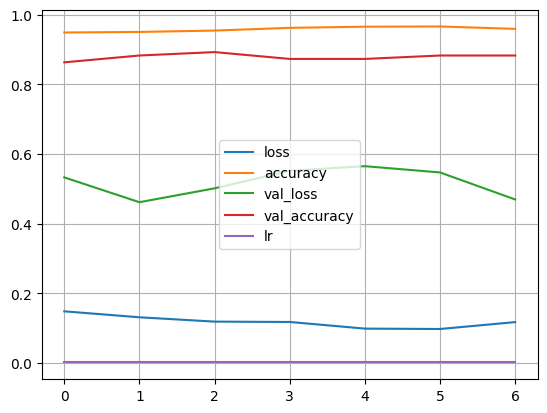


 6-Evalution


100%|██████████| 127/127 [00:01<00:00, 109.99it/s]


4/4 [==============================] - 0s 38ms/step

------------filtro de classificação errada---------------
k - fnames - labes - predic
6 - C:\Users\jczarsGamer\anaconda3\PSEUDO_LABELLING\BI_5/labels/equatorial_circular/20.Olea (43).png - equatorial_circular - polar_tricircular
10 - C:\Users\jczarsGamer\anaconda3\PSEUDO_LABELLING\BI_5/labels/polar_circular/17.Oxalis (86).png - polar_circular - equatorial_circular
13 - C:\Users\jczarsGamer\anaconda3\PSEUDO_LABELLING\BI_5/labels/polar_circular/9.Origanum (43).png - polar_circular - equatorial_circular
29 - C:\Users\jczarsGamer\anaconda3\PSEUDO_LABELLING\BI_5/labels/polar_circular/10.Satureja (37).png - polar_circular - equatorial_circular
37 - C:\Users\jczarsGamer\anaconda3\PSEUDO_LABELLING\BI_5/labels/equatorial_circular/8.Vitis (11).png - equatorial_circular - equatorial_alongada
40 - C:\Users\jczarsGamer\anaconda3\PSEUDO_LABELLING\BI_5/labels/polar_circular/9.Origanum (133).png - polar_circular - equatorial_eliptica
57 - C:\Users\j

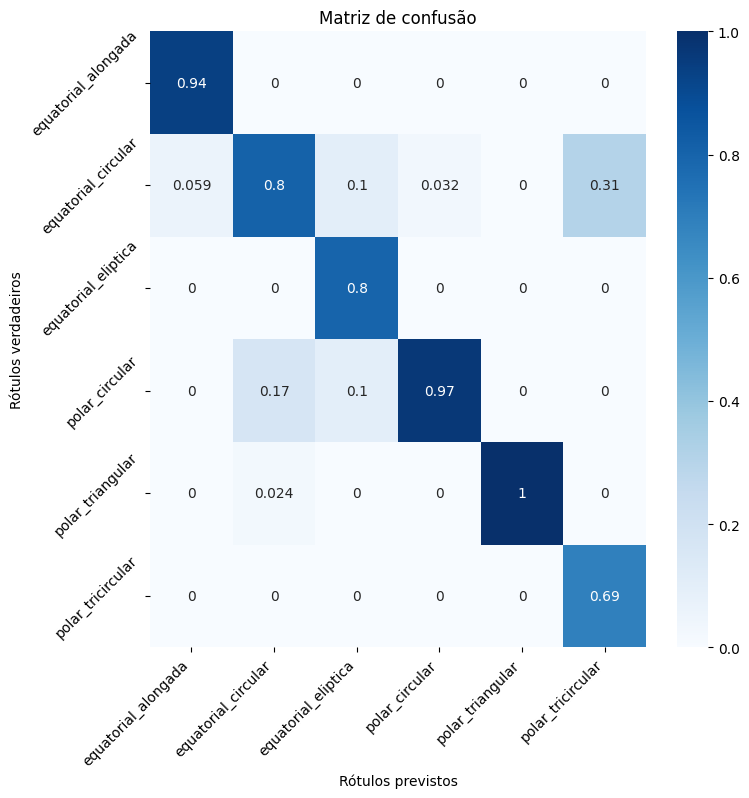

Classification Report
                     precision    recall  f1-score   support

equatorial_alongada       0.94      1.00      0.97        16
equatorial_circular       0.80      0.82      0.81        40
equatorial_eliptica       0.80      1.00      0.89         8
     polar_circular       0.97      0.79      0.87        38
   polar_triangular       1.00      0.94      0.97        16
  polar_tricircular       0.69      1.00      0.82         9

           accuracy                           0.87       127
          macro avg       0.87      0.93      0.89       127
       weighted avg       0.89      0.87      0.87       127

4/4 [==============================] - 0s 44ms/step - loss: 0.4685 - accuracy: 0.8824
(0.47, 0.88, 0.87, 0.87, 0.93, 0.89, 0.84)
tempo, rotulados, não rotulados, val_loss, val_acc, acc, seleção
[[0, 635, 3273, 0.23, 0.92, 568], [1, 1270, 3273, 0.24, 0.9, 568], [2, 2540, 2705, 0.33, 0.92, 492], [3, 5080, 2213, 0.33, 0.89, 406], [4, 10160, 1807, 0.42, 0.86, 316], [

100%|██████████| 205/205 [00:01<00:00, 108.40it/s]



Class-classificando as imagens :  (205, 224, 224, 3)
7/7 [==============================] - 1s 66ms/step
ini  205  fim  410


100%|██████████| 205/205 [00:01<00:00, 111.68it/s]



Class-classificando as imagens :  (205, 224, 224, 3)
7/7 [==============================] - 0s 45ms/step
ini  410  fim  617


100%|██████████| 207/207 [00:01<00:00, 112.08it/s]



Class-classificando as imagens :  (207, 224, 224, 3)
7/7 [==============================] - 0s 46ms/step
build

Class-salvando unlabels tempo 7, C:\Users\jczarsGamer\anaconda3\PSEUDO_LABELLING\CLASS_PSEUDO/0_Mobilenet_sem_BI_5/Train_0_Mobilenet_sem_BI_5/pseudo_csv/unlabelSet_t7.csv
                     file  conf
labels                         
equatorial_circular     5     5
polar_circular          7     7
polar_triangular      415   415
polar_tricircular     190   190
Total de dados classificados  617
Número de objetos coletados pela função GC: 36211
Objetos restantes: []

Step 3.5- Seleção

Select- Filtrar por confiança
Select- Tamanho data_uns 617
equatorial_alongada 0
equatorial_circular 5
equatorial_eliptica 0
polar_circular 7
polar_triangular 415
polar_tricircular 190
Select- menor 100

Select- seleção de novos pseudos

--------------build-----------------
\categoria     equatorial_alongada
tamanho do df 190
new_data_uns  617
\categoria     equatorial_circular
tamanho do df 0
n

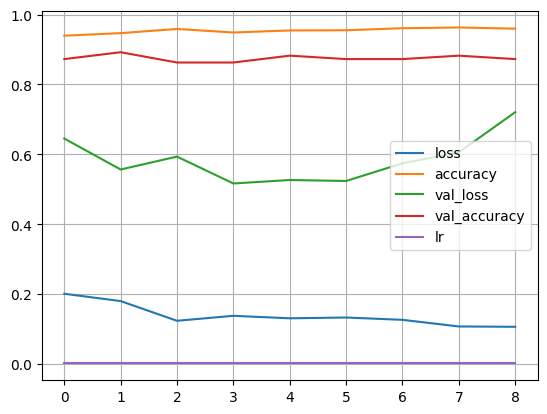


 6-Evalution


100%|██████████| 127/127 [00:01<00:00, 108.11it/s]


4/4 [==============================] - 0s 42ms/step

------------filtro de classificação errada---------------
k - fnames - labes - predic
6 - C:\Users\jczarsGamer\anaconda3\PSEUDO_LABELLING\BI_5/labels/equatorial_circular/20.Olea (43).png - equatorial_circular - polar_tricircular
12 - C:\Users\jczarsGamer\anaconda3\PSEUDO_LABELLING\BI_5/labels/equatorial_alongada/15.Ferula (35).png - equatorial_alongada - polar_circular
29 - C:\Users\jczarsGamer\anaconda3\PSEUDO_LABELLING\BI_5/labels/polar_circular/10.Satureja (37).png - polar_circular - equatorial_circular
37 - C:\Users\jczarsGamer\anaconda3\PSEUDO_LABELLING\BI_5/labels/equatorial_circular/8.Vitis (11).png - equatorial_circular - equatorial_alongada
40 - C:\Users\jczarsGamer\anaconda3\PSEUDO_LABELLING\BI_5/labels/polar_circular/9.Origanum (133).png - polar_circular - equatorial_eliptica
46 - C:\Users\jczarsGamer\anaconda3\PSEUDO_LABELLING\BI_5/labels/equatorial_circular/13.Salvia (65).png - equatorial_circular - polar_circular
57 - C

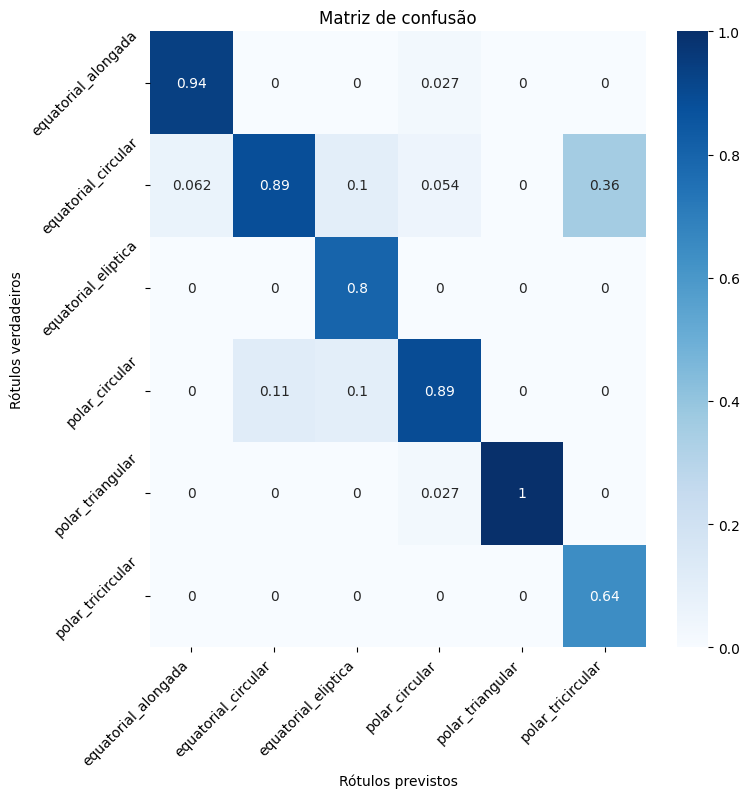

Classification Report
                     precision    recall  f1-score   support

equatorial_alongada       0.94      0.94      0.94        16
equatorial_circular       0.89      0.78      0.83        40
equatorial_eliptica       0.80      1.00      0.89         8
     polar_circular       0.89      0.87      0.88        38
   polar_triangular       1.00      0.94      0.97        16
  polar_tricircular       0.64      1.00      0.78         9

           accuracy                           0.87       127
          macro avg       0.86      0.92      0.88       127
       weighted avg       0.89      0.87      0.88       127

4/4 [==============================] - 0s 41ms/step - loss: 0.7207 - accuracy: 0.8725
(0.72, 0.87, 0.87, 0.86, 0.92, 0.88, 0.84)
tempo, rotulados, não rotulados, val_loss, val_acc, acc, seleção
[[0, 635, 3273, 0.23, 0.92, 568], [1, 1270, 3273, 0.24, 0.9, 568], [2, 2540, 2705, 0.33, 0.92, 492], [3, 5080, 2213, 0.33, 0.89, 406], [4, 10160, 1807, 0.42, 0.86, 316], [

100%|██████████| 135/135 [00:01<00:00, 111.42it/s]



Class-classificando as imagens :  (135, 224, 224, 3)
5/5 [==============================] - 1s 57ms/step
ini  135  fim  270


100%|██████████| 135/135 [00:01<00:00, 110.58it/s]



Class-classificando as imagens :  (135, 224, 224, 3)
5/5 [==============================] - 0s 24ms/step
ini  270  fim  405


100%|██████████| 135/135 [00:01<00:00, 110.53it/s]



Class-classificando as imagens :  (135, 224, 224, 3)
5/5 [==============================] - 0s 23ms/step
build

Class-salvando unlabels tempo 8, C:\Users\jczarsGamer\anaconda3\PSEUDO_LABELLING\CLASS_PSEUDO/0_Mobilenet_sem_BI_5/Train_0_Mobilenet_sem_BI_5/pseudo_csv/unlabelSet_t8.csv
                     file  conf
labels                         
equatorial_circular     2     2
polar_circular          1     1
polar_triangular      304   304
polar_tricircular      98    98
Total de dados classificados  405
Número de objetos coletados pela função GC: 33084
Objetos restantes: []

Step 3.5- Seleção

Select- Filtrar por confiança
Select- Tamanho data_uns 405
equatorial_alongada 0
equatorial_circular 2
equatorial_eliptica 0
polar_circular 1
polar_triangular 304
polar_tricircular 98
Select- menor 100

Select- seleção de novos pseudos

--------------build-----------------
\categoria     equatorial_alongada
tamanho do df 98
new_data_uns  405
\categoria     equatorial_circular
tamanho do df 0
new

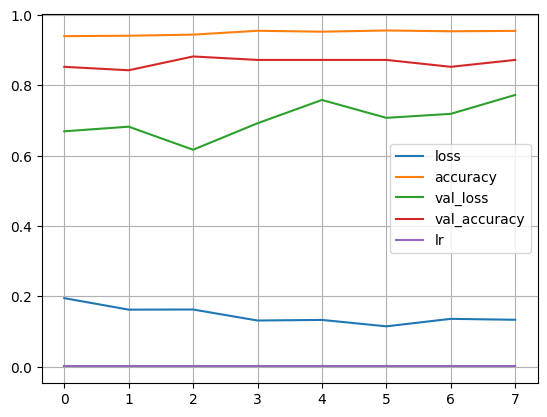


 6-Evalution


100%|██████████| 127/127 [00:01<00:00, 111.51it/s]


4/4 [==============================] - 0s 44ms/step

------------filtro de classificação errada---------------
k - fnames - labes - predic
6 - C:\Users\jczarsGamer\anaconda3\PSEUDO_LABELLING\BI_5/labels/equatorial_circular/20.Olea (43).png - equatorial_circular - polar_tricircular
29 - C:\Users\jczarsGamer\anaconda3\PSEUDO_LABELLING\BI_5/labels/polar_circular/10.Satureja (37).png - polar_circular - equatorial_circular
37 - C:\Users\jczarsGamer\anaconda3\PSEUDO_LABELLING\BI_5/labels/equatorial_circular/8.Vitis (11).png - equatorial_circular - equatorial_alongada
40 - C:\Users\jczarsGamer\anaconda3\PSEUDO_LABELLING\BI_5/labels/polar_circular/9.Origanum (133).png - polar_circular - equatorial_eliptica
42 - C:\Users\jczarsGamer\anaconda3\PSEUDO_LABELLING\BI_5/labels/equatorial_circular/6.Ceratonia (40).png - equatorial_circular - polar_tricircular
57 - C:\Users\jczarsGamer\anaconda3\PSEUDO_LABELLING\BI_5/labels/equatorial_circular/20.Olea (44).png - equatorial_circular - polar_tricircular


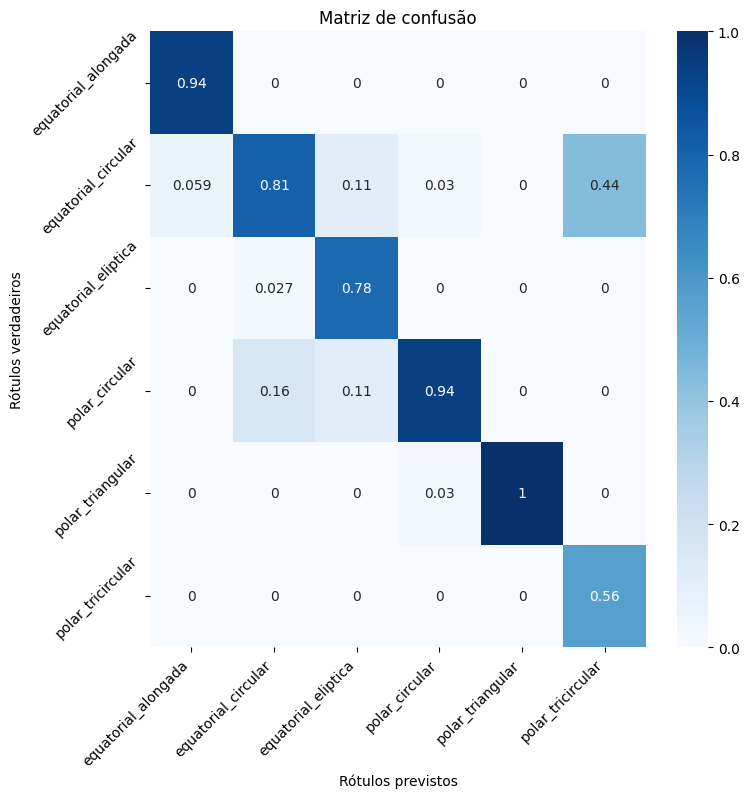

Classification Report
                     precision    recall  f1-score   support

equatorial_alongada       0.94      1.00      0.97        16
equatorial_circular       0.81      0.75      0.78        40
equatorial_eliptica       0.78      0.88      0.82         8
     polar_circular       0.94      0.82      0.87        38
   polar_triangular       1.00      0.94      0.97        16
  polar_tricircular       0.56      1.00      0.72         9

           accuracy                           0.85       127
          macro avg       0.84      0.90      0.86       127
       weighted avg       0.87      0.85      0.85       127

4/4 [==============================] - 0s 39ms/step - loss: 0.7735 - accuracy: 0.8725
(0.77, 0.87, 0.85, 0.84, 0.9, 0.86, 0.81)
tempo, rotulados, não rotulados, val_loss, val_acc, acc, seleção
[[0, 635, 3273, 0.23, 0.92, 568], [1, 1270, 3273, 0.24, 0.9, 568], [2, 2540, 2705, 0.33, 0.92, 492], [3, 5080, 2213, 0.33, 0.89, 406], [4, 10160, 1807, 0.42, 0.86, 316], [5

100%|██████████| 68/68 [00:00<00:00, 112.74it/s]



Class-classificando as imagens :  (68, 224, 224, 3)
3/3 [==============================] - 0s 42ms/step
ini  68  fim  136


100%|██████████| 68/68 [00:00<00:00, 112.60it/s]



Class-classificando as imagens :  (68, 224, 224, 3)
3/3 [==============================] - 0s 38ms/step
ini  136  fim  204


100%|██████████| 68/68 [00:00<00:00, 114.00it/s]


Class-classificando as imagens :  (68, 224, 224, 3)
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 38ms/step
build

Class-salvando unlabels tempo 9, C:\Users\jczarsGamer\anaconda3\PSEUDO_LABELLING\CLASS_PSEUDO/0_Mobilenet_sem_BI_5/Train_0_Mobilenet_sem_BI_5/pseudo_csv/unlabelSet_t9.csv
                   file  conf
labels                       
polar_circular        1     1
polar_triangular    182   182
polar_tricircular    21    21
Total de dados classificados  204
Número de objetos coletados pela função GC: 32977
Objetos restantes: []

Step 3.5- Seleção

Select- Filtrar por confiança
Select- Tamanho data_uns 204
equatorial_alongada 0
equatorial_circular 0
equatorial_eliptica 0
polar_circular 1
polar_triangular 182
polar_tricircular 21
Select- menor 100

Select- seleção de novos pseudos

--------------build-----------------
\categoria     equatorial_alongada
tamanho do df 21
new_data_uns  204
\categoria     equatorial_circular
tamanho do df 0
new_data_uns  204
\categoria     equatorial_eliptica
tamanho do df 0
new_data_uns  204
\categoria  

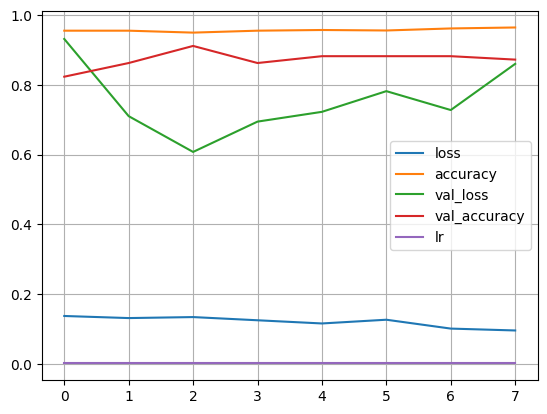


 6-Evalution


100%|██████████| 127/127 [00:01<00:00, 102.13it/s]


4/4 [==============================] - 0s 38ms/step

------------filtro de classificação errada---------------
k - fnames - labes - predic
6 - C:\Users\jczarsGamer\anaconda3\PSEUDO_LABELLING\BI_5/labels/equatorial_circular/20.Olea (43).png - equatorial_circular - polar_tricircular
29 - C:\Users\jczarsGamer\anaconda3\PSEUDO_LABELLING\BI_5/labels/polar_circular/10.Satureja (37).png - polar_circular - equatorial_circular
37 - C:\Users\jczarsGamer\anaconda3\PSEUDO_LABELLING\BI_5/labels/equatorial_circular/8.Vitis (11).png - equatorial_circular - equatorial_alongada
40 - C:\Users\jczarsGamer\anaconda3\PSEUDO_LABELLING\BI_5/labels/polar_circular/9.Origanum (133).png - polar_circular - equatorial_eliptica
42 - C:\Users\jczarsGamer\anaconda3\PSEUDO_LABELLING\BI_5/labels/equatorial_circular/6.Ceratonia (40).png - equatorial_circular - polar_tricircular
43 - C:\Users\jczarsGamer\anaconda3\PSEUDO_LABELLING\BI_5/labels/polar_triangular/4.Eucalyptus (129).png - polar_triangular - polar_tricircular


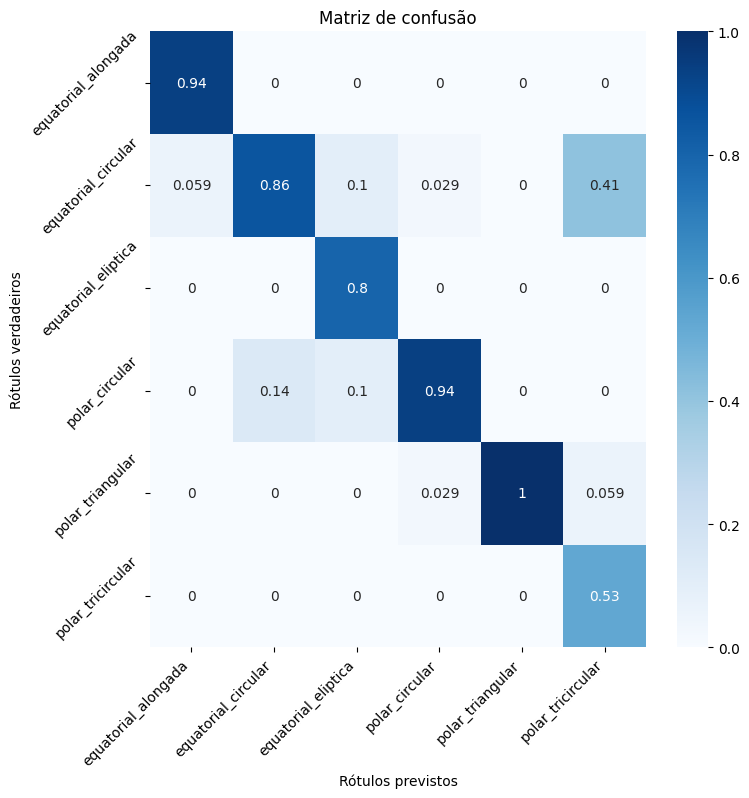

Classification Report
                     precision    recall  f1-score   support

equatorial_alongada       0.94      1.00      0.97        16
equatorial_circular       0.86      0.75      0.80        40
equatorial_eliptica       0.80      1.00      0.89         8
     polar_circular       0.94      0.84      0.89        38
   polar_triangular       1.00      0.88      0.93        16
  polar_tricircular       0.53      1.00      0.69         9

           accuracy                           0.86       127
          macro avg       0.84      0.91      0.86       127
       weighted avg       0.88      0.86      0.86       127

4/4 [==============================] - 0s 50ms/step - loss: 0.8595 - accuracy: 0.8725
(0.86, 0.87, 0.86, 0.84, 0.91, 0.86, 0.82)
tempo, rotulados, não rotulados, val_loss, val_acc, acc, seleção
[[0, 635, 3273, 0.23, 0.92, 568], [1, 1270, 3273, 0.24, 0.9, 568], [2, 2540, 2705, 0.33, 0.92, 492], [3, 5080, 2213, 0.33, 0.89, 406], [4, 10160, 1807, 0.42, 0.86, 316], [

100%|██████████| 27/27 [00:00<00:00, 108.71it/s]



Class-classificando as imagens :  (27, 224, 224, 3)
1/1 [==============================] - 0s 331ms/step
ini  27  fim  54


100%|██████████| 27/27 [00:00<00:00, 113.13it/s]


Class-classificando as imagens :  (27, 224, 224, 3)
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step
ini  54  fim  82


100%|██████████| 28/28 [00:00<00:00, 113.94it/s]


Class-classificando as imagens :  (28, 224, 224, 3)
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step
build

Class-salvando unlabels tempo 10, C:\Users\jczarsGamer\anaconda3\PSEUDO_LABELLING\CLASS_PSEUDO/0_Mobilenet_sem_BI_5/Train_0_Mobilenet_sem_BI_5/pseudo_csv/unlabelSet_t10.csv
                   file  conf
labels                       
polar_circular        1     1
polar_triangular     69    69
polar_tricircular    12    12
Total de dados classificados  82
Número de objetos coletados pela função GC: 32865
Objetos restantes: []

Step 3.5- Seleção

Select- Filtrar por confiança
Select- Tamanho data_uns 82
equatorial_alongada 0
equatorial_circular 0
equatorial_eliptica 0
polar_circular 1
polar_triangular 69
polar_tricircular 12
Select- menor 100

Select- seleção de novos pseudos

--------------build-----------------
\categoria     equatorial_alongada
tamanho do df 12
new_data_uns  82
\categoria     equatorial_circular
tamanho do df 0
new_data_uns  82
\categoria     equatorial_eliptica
tamanho do df 0
new_data_uns  82
\categoria     p

IndexError: list index out of range

In [41]:
if __name__=="__main__":
  _nm=0
  _path=r"C:\Users\jczarsGamer\anaconda3\PSEUDO_LABELLING\CLASS_PSEUDO"
  _base='BI_5'
  _path_BD=r"C:\Users\jczarsGamer\anaconda3\PSEUDO_LABELLING\BI_5"
  _test_aug_sel=[
    ['Mobilenet', 'sem'],
    ['DenseNet201', 'sem'],
    ['InceptionResNetV2', 'sem'],
    ['InceptionV3', 'sem'],
    ['ResNet152V2', 'sem'],
    ['Xception', 'sem'],
    ['VGG16', 'sem'],
    ['VGG19', 'sem'],
    ['NASNetLarge', 'sem']
  ]
  for i in _test_aug_sel:
    print(_nm,i[0], i[1])
    run(_nm, _path,i[0], i[1], _base, _path_BD)
    _nm=_nm+1